# setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install umap-learn

In [3]:
import pickle
import numpy as np

# import umap
import matplotlib.pyplot as plt

# load weight mats

In [ ]:
# Define the path to your pickle file in Google Drive
file_path = '/content/drive/MyDrive/ts-1L-21M_Wdec.pkl'  # Change the path if necessary

# Load the weight matrix from the pickle file
with open(file_path, 'rb') as f:
    weight_matrix_np = pickle.load(f)

# Optionally, check the shape of the loaded weight matrix
print(weight_matrix_np.shape)

torch.Size([16384, 1024])


In [ ]:
weight_matrix_np = weight_matrix_np.detach().numpy()

In [ ]:
# Define the path to your pickle file in Google Drive
file_path = '/content/drive/MyDrive/ts-2L-33M_Wdec.pkl'  # Change the path if necessary

# Load the weight matrix from the pickle file
with open(file_path, 'rb') as f:
    weight_matrix_2 = pickle.load(f)

# Optionally, check the shape of the loaded weight matrix
print(weight_matrix_2.shape)

torch.Size([16384, 1024])


In [ ]:
weight_matrix_2 = weight_matrix_2.detach().numpy()

# load sae f actvs

In [4]:
file_path = '/content/drive/MyDrive/fActs_ts_1L_21M_anySamps_v1.pkl'
with open(file_path, 'rb') as f:
    feature_acts_model_A = pickle.load(f)

In [5]:
file_path = '/content/drive/MyDrive/fActs_ts_2L_33M_anySamps_v1.pkl'
with open(file_path, 'rb') as f:
    feature_acts_model_B = pickle.load(f)

In [6]:
feature_acts_model_B.shape

torch.Size([500, 128, 16384])

In [7]:
first_dim_reshaped = feature_acts_model_A.shape[0] * feature_acts_model_A.shape[1]
reshaped_activations_A = feature_acts_model_A.reshape(first_dim_reshaped, feature_acts_model_A.shape[-1]).cpu()
reshaped_activations_B = feature_acts_model_B.reshape(first_dim_reshaped, feature_acts_model_B.shape[-1]).cpu()

In [8]:
reshaped_activations_B.shape

torch.Size([64000, 16384])

# load feature labels

## load

In [ ]:
import json
with open('feature_top_samps_lst_1L_16k.json', 'rb') as f:
    feat_snip_dict = json.load(f)

In [ ]:
with open('feature_top_samps_lst_2L_MLP0_16k.json', 'rb') as f:
    feat_snip_dict_2 = json.load(f)

In [ ]:
import re

def extract_tagged_word(s):
    # Define the regex pattern to match the tagged word
    pattern = r'\[bold u dark_orange\](.*?)\[/\]'

    # Search for the pattern in the string
    match = re.search(pattern, s)

    # If a match is found, return the captured group (the word inside the tags)
    if match:
        return match.group(1)
    else:
        return None

In [ ]:
fList_model_A = []
for feat_dict in feat_snip_dict:
    # text = feat_dict['strings'][0]
    # result = extract_tagged_word(text)
    # fList_model_A.append(result)
    out_str = ''
    for text in feat_dict['strings']:
        result = extract_tagged_word(text)
        out_str += result + ', '
    fList_model_A.append(out_str)

In [ ]:
fList_model_B = []
for feat_dict in feat_snip_dict_2:
    out_str = ''
    for text in feat_dict['strings']:
        result = extract_tagged_word(text)
        out_str += result + ', '
    fList_model_B.append(out_str)

## save spliced labels

In [ ]:
with open('fList_model_A.pkl', 'wb') as f:
    pickle.dump(fList_model_A, f)
with open('fList_model_B.pkl', 'wb') as f:
    pickle.dump(fList_model_B, f)

In [ ]:
from google.colab import files
files.download('fList_model_A.pkl')
files.download('fList_model_B.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
with open('fList_model_A.pkl', 'rb') as f:
    fList_model_A = pickle.load(f)
with open('fList_model_B.pkl', 'rb') as f:
    fList_model_B = pickle.load(f)

# load corr

In [ ]:
import pickle
with open('highest_corr_inds_1L_2L_MLP0_16k_30k_relu.pkl', 'rb') as f:
    highest_correlations_indices_v1 = pickle.load(f)
with open('highest_corr_vals_1L_2L_MLP0_16k_30k_relu.pkl', 'rb') as f:
    highest_correlations_values_v1 = pickle.load(f)

# corr mat

## plot feature actv corrs

In [ ]:
import matplotlib.pyplot as plt

0.632544421789805


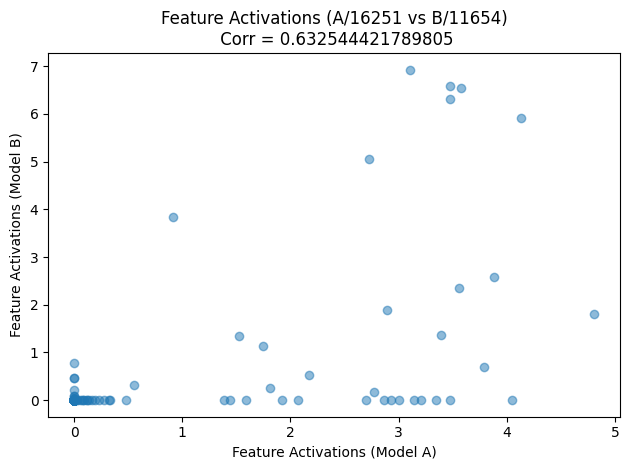

In [ ]:
model_A_f_ind = 11654
model_B_f_ind = 3103

feature_0_actvs_A = reshaped_activations_A[:, model_A_f_ind].numpy()
feature_0_actvs_B = reshaped_activations_B[:, model_B_f_ind].numpy()

corr = np.corrcoef(feature_0_actvs_A, feature_0_actvs_B)[0, 1]
print(corr)

plt.scatter(feature_0_actvs_A, feature_0_actvs_B, alpha=0.5)

plt.xlabel('Feature Activations (Model A)')
plt.ylabel('Feature Activations (Model B)')
plt.title('Feature Activations (A/16251 vs B/11654)\n Corr = ' + str(corr))

plt.tight_layout()
plt.show()

## get all actv corrs

In [ ]:
import torch
import numpy as np

def top_ind_from_B(ind, reshaped_activations_A, reshaped_activations_B):
    # Select a column from matrix B
    column_A = reshaped_activations_B[:, ind]

    # Ensure tensors are on GPU
    if torch.cuda.is_available():
        reshaped_activations_A = reshaped_activations_A.to('cuda')
        reshaped_activations_B = reshaped_activations_B.to('cuda')
        column_A = column_A.to('cuda')

    # Calculate means and standard deviations
    mean_A = column_A.mean()
    std_A = column_A.std()

    # Mask columns with zero standard deviation
    std_B = reshaped_activations_A.std(dim=0)
    valid_columns_mask = std_B != 0

    # Compute correlations for valid columns
    valid_reshaped_activations_A = reshaped_activations_A[:, valid_columns_mask]
    mean_B = valid_reshaped_activations_A.mean(dim=0)
    std_B = valid_reshaped_activations_A.std(dim=0)

    covariance = ((valid_reshaped_activations_A - mean_B) * (column_A - mean_A).unsqueeze(1)).mean(dim=0)
    correlations = covariance / (std_A * std_B)

    # Fill correlations with -inf where columns were invalid
    all_correlations = torch.full((reshaped_activations_A.shape[1],), float('-inf')).to(correlations.device)
    all_correlations[valid_columns_mask] = correlations

    # Get the indices of the top 10 columns in B with the highest correlations
    top_10_indices = torch.topk(all_correlations, 1).indices.cpu().numpy()
    top_10_correlations = all_correlations[top_10_indices].cpu().numpy()

    return top_10_indices, top_10_correlations

In [ ]:
def find_all_highest_correlations(reshaped_activations_A, reshaped_activations_B):
    # Ensure tensors are on GPU
    if torch.cuda.is_available():
        reshaped_activations_A = reshaped_activations_A.to('cuda')
        reshaped_activations_B = reshaped_activations_B.to('cuda')

    # Normalize columns of A
    mean_A = reshaped_activations_A.mean(dim=0, keepdim=True)
    std_A = reshaped_activations_A.std(dim=0, keepdim=True)
    normalized_A = (reshaped_activations_A - mean_A) / (std_A + 1e-8)  # Avoid division by zero

    # Normalize columns of B
    mean_B = reshaped_activations_B.mean(dim=0, keepdim=True)
    std_B = reshaped_activations_B.std(dim=0, keepdim=True)
    normalized_B = (reshaped_activations_B - mean_B) / (std_B + 1e-8)  # Avoid division by zero

    # Compute correlation matrix
    correlation_matrix = torch.matmul(normalized_A.t(), normalized_B) / normalized_A.shape[0]

    # Handle NaNs by setting them to -inf
    correlation_matrix = torch.where(torch.isnan(correlation_matrix), torch.tensor(float('-inf')).to(correlation_matrix.device), correlation_matrix)

    # Get the highest correlation indices and values
    highest_correlations_values, highest_correlations_indices = correlation_matrix.max(dim=0)

    # Move results back to CPU
    highest_correlations_indices = highest_correlations_indices.cpu().numpy()
    highest_correlations_values = highest_correlations_values.cpu().numpy()

    return highest_correlations_indices, highest_correlations_values

In [ ]:
highest_correlations_indices, highest_correlations_values = find_all_highest_correlations(reshaped_activations_A, reshaped_activations_B)
print(f'Highest correlations indices: {highest_correlations_indices}')
print(f'Highest correlations values: {highest_correlations_values}')

In [ ]:
highest_correlations_indices[:100]

array([ 5561, 15125, 14623,  8628, 12995, 15964, 12440, 16310,  6360,
        4538,  5225,  8931,     0,  9435,  7193,  9390,  2010, 15595,
        1309,  6360,  9393, 16063,   384,   441, 13982, 14593, 13763,
         560,  4131,  3115, 11445, 16025, 12631,  2658, 16050, 15617,
       14301, 10218,  3316,  4924,  2896,  5917,  5311,  8945, 16219,
       12104, 11352,     0, 12855, 13316, 10460, 14175, 14790,  6012,
           0, 12990,  3639,  7861, 11677,  6964,  8036, 12572,     0,
       12067,  4792,  5505, 10286,   445,   514,  7165, 15249,    24,
           0,  4597,  3918,  9250, 12228, 14177, 10100, 10105,  4695,
        2548,  3076, 12545, 11103, 15131, 11101,  7441,  4950, 12526,
        3007, 13211, 12909, 14446, 10146, 14192,  7380,  9130,     0,
       13100])

### save corrs

In [ ]:
import pickle

In [ ]:
with open('highest_correlations_indices_v1.pkl', 'wb') as f:
    pickle.dump(highest_correlations_indices, f)
with open('highest_correlations_values_v1.pkl', 'wb') as f:
    pickle.dump(highest_correlations_values, f)

In [ ]:
from google.colab import files
files.download('highest_correlations_indices_v1.pkl')
files.download('highest_correlations_values_v1.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !cp batch_tokens_anySamps_v1.pkl /content/drive/MyDrive/

# load model

In [ ]:
from transformers import AutoTokenizer

# Load the tokenizer for the specified model
tokenizer = AutoTokenizer.from_pretrained("roneneldan/TinyStories-1Layer-21M")

tokenizer_config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

{'input_ids': [7454, 2402, 257, 640, 11, 612, 373, 257, 7009, 1621, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
# Convert a single string to a token ID
single_string = "example"
token_id = tokenizer.encode(single_string, add_special_tokens=False)[0]
decoded_string = tokenizer.decode([token_id])
print(decoded_string)

example


# interpret paired features

## load dataset tokens

In [ ]:
import pickle
file_path = '/content/drive/MyDrive/batch_tokens_anySamps_v1.pkl'
with open(file_path, 'rb') as f:
    batch_tokens = pickle.load(f)

## interpret

In [ ]:
%pip install jaxtyping

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.0 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn, Tensor
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple

In [ ]:
def highest_activating_tokens(
    feature_acts,
    feature_idx: int,
    k: int = 10,  # num batch_seq samples
    batch_tokens=None
) -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    batch_size, seq_len = batch_tokens.shape

    # Get the top k largest activations for only targeted feature
    # need to flatten (batch,seq) into batch*seq first because it's ANY batch_seq, even if in same batch or same pos
    flattened_feature_acts = feature_acts[:, :, feature_idx].reshape(-1)

    top_acts_values, top_acts_indices = flattened_feature_acts.topk(k)
    # top_acts_values should be 1D
    # top_acts_indices should be also be 1D. Now, turn it back to 2D
    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return torch.stack([top_acts_batch, top_acts_seq], dim=-1), top_acts_values

In [ ]:
from rich import print as rprint
def display_top_sequences(top_acts_indices, top_acts_values, batch_tokens):
    s = ""
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        # s += f'{batch_idx}\n'
        s += f'batchID: {batch_idx}, '
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq_start = max(seq_idx - 5, 0)
        seq_end = min(seq_idx + 5, batch_tokens.shape[1])
        seq = ""
        # Loop over the sequence, adding each token to the string (highlighting the token with the large activations)
        for i in range(seq_start, seq_end):
            # new_str_token = model.to_single_str_token(batch_tokens[batch_idx, i].item()).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            new_str_token = tokenizer.decode([batch_tokens[batch_idx, i].item()]).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            if i == seq_idx:
                new_str_token = f"[bold u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Print the sequence, and the activation value
        s += f'Act = {value:.2f}, Seq = "{seq}"\n'

    rprint(s)

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_B, feature_idx_A in enumerate(highest_correlations_indices[:10]):
    print(f'Correlation: {highest_correlations_values[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=batch_tokens)
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=batch_tokens)

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=batch_tokens)
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=batch_tokens)

    print('-'*50)

Correlation: 0.618808388710022
Model A Feature:  5561


batchID: 306, Act = 1.65, Seq = " soon.Ben and Tom are friends. They like"
batchID: 261, Act = 1.54, Seq = " and the paper. They are not happy. They"
batchID: 354, Act = 1.40, Seq = " lot.\n\nBen is sad too. He"
batchID: 335, Act = 1.30, Seq = "\n\nAnna and Ben are sad and angry."
batchID: 260, Act = 1.29, Seq = " wait for Christmas. They are confused. What should"

Model B Feature:  0


batchID: 309, Act = 3.69, Seq = " at each other. They are still friends. They"
batchID: 257, Act = 3.39, Seq = " and chicken too. They are all good for you"
batchID: 363, Act = 3.35, Seq = " at his ball. He is sad. He cannot"
batchID: 260, Act = 3.21, Seq = "\n\nAnna and Ben are very happy. They"
batchID: 410, Act = 3.20, Seq = " catching the ball. They are having fun.\n"

--------------------------------------------------
Correlation: 0.9358087182044983
Model A Feature:  15125


batchID: 136, Act = 6.29, Seq = ". One day, she was walking in the park"
batchID: 477, Act = 5.96, Seq = ". One day, he was playing with his cards"
batchID: 446, Act = 5.73, Seq = ". One day, Lily was playing in her wardrobe"
batchID: 141, Act = 5.51, Seq = " One day, she was playing with her friends"
batchID: 441, Act = 5.50, Seq = ". One day, Lily was playing outside when the"

Model B Feature:  1


batchID: 141, Act = 5.84, Seq = " One day, she was playing with her friends"
batchID: 82, Act = 5.81, Seq = ". One day, Tom was walking on the street"
batchID: 50, Act = 5.44, Seq = "\nOne day, Mia was very tired. She"
batchID: 477, Act = 5.24, Seq = ". One day, he was playing with his cards"
batchID: 136, Act = 5.21, Seq = ". One day, she was walking in the park"

--------------------------------------------------
Correlation: 0.5587209463119507
Model A Feature:  14623


batchID: 40, Act = 6.42, Seq = " plate. Lily ate them all up and smiled."
batchID: 440, Act = 5.42, Seq = " she had to eat it all or else her mom"
batchID: 23, Act = 4.40, Seq = "I will not eat it all."\n\nTim"
batchID: 348, Act = 4.12, Seq = " of you. You ate all your vegetables. You"
batchID: 23, Act = 4.09, Seq = " you must not eat it all. If you do"

Model B Feature:  2


batchID: 24, Act = 7.96, Seq = " the man. He ate all the candy. Suddenly"
batchID: 348, Act = 7.34, Seq = " of you. You ate all your vegetables. You"
batchID: 233, Act = 7.33, Seq = " was very happy and ate all the corn.\n"
batchID: 451, Act = 6.38, Seq = " sister's toys and eat all the cookies. One"
batchID: 40, Act = 4.95, Seq = " plate. Lily ate them all up and smiled."

--------------------------------------------------
Correlation: 0.293124258518219
Model A Feature:  8628


batchID: 346, Act = 3.35, Seq = " how to have fun. He hoped she would not"
batchID: 423, Act = 2.55, Seq = " would not see her. She was sorry.Once"
batchID: 346, Act = 2.48, Seq = " come and be nice. He hoped she would learn"
batchID: 345, Act = 2.36, Seq = " him to be happy. She did not want to"
batchID: 325, Act = 2.29, Seq = " would like her picture. She helped her mom clean"

Model B Feature:  3


batchID: 263, Act = 0.34, Seq = " why they were different. She examined her toys,"
batchID: 263, Act = 0.29, Seq = " them and ask questions. She wanted to know how"
batchID: 262, Act = 0.28, Seq = " have to say sorry. They tell them that they"
batchID: 300, Act = 0.27, Seq = " know what is inside. They look for a key"
batchID: 298, Act = 0.25, Seq = " know what to say. She looked at Lily and"

--------------------------------------------------
Correlation: 0.8715307712554932
Model A Feature:  12995


batchID: 445, Act = 5.22, Seq = " put on the apron right away. \n"
batchID: 91, Act = 5.10, Seq = " very excited and started drawing right away. She worked"
batchID: 275, Act = 4.47, Seq = " Mom said she would come right away. She told"
batchID: 197, Act = 4.13, Seq = " Timmy wanted to explore right away. He saw"
batchID: 60, Act = 2.48, Seq = " tent was set up just right. \n\n"

Model B Feature:  4


batchID: 197, Act = 7.60, Seq = " Timmy wanted to explore right away. He saw"
batchID: 91, Act = 7.05, Seq = " very excited and started drawing right away. She worked"
batchID: 445, Act = 6.74, Seq = " put on the apron right away. \n"
batchID: 275, Act = 4.00, Seq = " Mom said she would come right away. She told"
batchID: 179, Act = 2.08, Seq = " how to design it just right.\n\nBut"

--------------------------------------------------
Correlation: 0.2184809148311615
Model A Feature:  15964


batchID: 360, Act = 1.42, Seq = " to eat your cake and tea."\n\nL"
batchID: 201, Act = 1.29, Seq = " wash it with soap and water." \n\n"
batchID: 324, Act = 1.02, Seq = " on the table and the floor. We need to"
batchID: 373, Act = 0.96, Seq = " will help you relax and fall asleep."\n\n"
batchID: 27, Act = 0.86, Seq = " let's lie down and rest. Then we can"

Model B Feature:  5


batchID: 74, Act = 1.88, Seq = " up high to try and touch the statue's nose"
batchID: 186, Act = 1.74, Seq = " let's go home and take a nap." "
batchID: 51, Act = 1.74, Seq = "uffy wanted to escape and explore the world outside the"
batchID: 27, Act = 1.72, Seq = " want to lie down and rest."\n\nTim"
batchID: 409, Act = 1.71, Seq = ""Let's go and look," says Tim."

--------------------------------------------------
Correlation: 0.35061749815940857
Model A Feature:  12440


batchID: 480, Act = 2.28, Seq = " a lot. He never saw his daughter again."
batchID: 235, Act = 2.19, Seq = " was very lazy and never wanted to do anything."
batchID: 63, Act = 1.54, Seq = " Sadly, they were never found and the flowers in"
batchID: 447, Act = 1.45, Seq = " the wardrobe and was never seen again.Once upon"
batchID: 54, Act = 1.41, Seq = " he thought he would never see his"

Model B Feature:  6


batchID: 46, Act = 2.12, Seq = " explore and examine everything he saw.\n\nAs"
batchID: 480, Act = 2.02, Seq = " a lot. He never saw his daughter again."
batchID: 249, Act = 1.34, Seq = " asked her where she last saw it. She said"
batchID: 54, Act = 1.26, Seq = " he thought he would never see his"
batchID: 410, Act = 1.08, Seq = ". They see a silly sight.\n\nThey"

--------------------------------------------------
Correlation: 0.8785818219184875
Model A Feature:  16310


batchID: 76, Act = 6.96, Seq = ". And the little girl never forgot how the robot"
batchID: 88, Act = 6.84, Seq = " day on, Timmy never dared Mittens to"
batchID: 425, Act = 6.66, Seq = " day on, the bird never had to refuse"
batchID: 72, Act = 6.26, Seq = " day on, the lion never went to the circus"
batchID: 127, Act = 6.10, Seq = " on, the two fishes never fought again. They"

Model B Feature:  7


batchID: 243, Act = 6.89, Seq = " value of old toys and never disagreed with Timmy"
batchID: 81, Act = 6.32, Seq = " around the toy stove and never touched the burners"
batchID: 55, Act = 6.04, Seq = " to take it easy and never give up when things"
batchID: 255, Act = 5.57, Seq = " stayed on the ground and never flew again.Tom"
batchID: 192, Act = 5.51, Seq = " cup was dependable and never spilled.\n\n"

--------------------------------------------------
Correlation: 0.7482732534408569
Model A Feature:  6360


batchID: 374, Act = 3.72, Seq = " closed his eyes and drifted off to sleep. Mom"
batchID: 85, Act = 3.27, Seq = " And so, they went off to explore the rest"
batchID: 190, Act = 3.22, Seq = " play!" And they ran off to play together."
batchID: 254, Act = 2.78, Seq = ". So, it took off and flew higher and"
batchID: 131, Act = 2.53, Seq = " for dinner, Lily took off the belt and put"

Model B Feature:  8


batchID: 366, Act = 4.89, Seq = "."\n\nThey got off their bikes and left"
batchID: 190, Act = 4.17, Seq = " play!" And they ran off to play together."
batchID: 85, Act = 3.26, Seq = " And so, they went off to explore the rest"
batchID: 374, Act = 3.04, Seq = " closed his eyes and drifted off to sleep. Mom"
batchID: 191, Act = 2.48, Seq = " Sarah. Sarah let Spot off his leash so he"

--------------------------------------------------
Correlation: 0.9201383590698242
Model A Feature:  4538


batchID: 107, Act = 4.13, Seq = " They folded the clothes and then put them in a"
batchID: 106, Act = 3.51, Seq = " clothes in the machine and then put them in the"
batchID: 378, Act = 3.49, Seq = " one more step, and then he heard a loud"
batchID: 48, Act = 2.58, Seq = " the nail all day and then went back to their"
batchID: 333, Act = 2.40, Seq = " one claims the cat, then maybe we can adopt"

Model B Feature:  9


batchID: 378, Act = 8.73, Seq = " one more step, and then he heard a loud"
batchID: 48, Act = 7.36, Seq = " the nail all day and then went back to their"
batchID: 107, Act = 7.22, Seq = " They folded the clothes and then put them in a"
batchID: 487, Act = 7.12, Seq = " it for a moment and then decided to give the"
batchID: 106, Act = 6.34, Seq = " clothes in the machine and then put them in the"

--------------------------------------------------


# search modB features with keyword, get modA f pair

## fns

In [ ]:
def find_indices_with_keyword(fList, keyword):
    """
    Find all indices of fList which contain the keyword in the string at those indices.

    Args:
    fList (list of str): List of strings to search within.
    keyword (str): Keyword to search for within the strings of fList.

    Returns:
    list of int: List of indices where the keyword is found within the strings of fList.
    """
    index_list = []
    for index, string in enumerate(fList):
        split_list = string.split(',')
        no_space_list = [i.replace(' ', '').lower() for i in split_list]
        if keyword in no_space_list:
            index_list.append(index)
    return index_list

In [ ]:
def get_values_from_indices(indices, values_list):
    """
    Get the values from values_list at the specified indices.

    Args:
    indices (list of int): List of indices to retrieve values from.
    values_list (list): List of values from which to retrieve the specified indices.

    Returns:
    list: List of values from values_list at the specified indices.
    """
    return [values_list[index] for index in indices]

## test

In [ ]:
keyword = "king"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
print(modA_feats)
print(modB_feats)

[11920, 11222]
[5430, 10868]


In [ ]:
print(fList_model_A[11920])
print(fList_model_B[5430])

 monster,  monster,  princess,  princess,  knight, 
 princess,  princess,  princess,  princess,  king, 


In [ ]:
keyword = "spot"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
print(modA_feats)
print(modB_feats)

[0, 12104, 0, 0, 0, 0, 2548, 0, 0, 14534, 9409, 0, 9282, 15926, 14668, 8930, 2925, 0, 0, 0, 4364, 7302, 13046, 13595, 0, 0, 0, 15246, 0, 0, 11313, 0, 2567, 0, 0, 0, 5510, 14787, 14126, 0, 0, 0, 13071, 14169, 0, 12638, 0, 0, 0, 748, 0, 0, 0, 0, 2101, 0, 0, 11735, 0, 0, 0, 663, 0, 6748, 0, 0, 0, 0, 15533, 0, 0, 0, 1164, 0, 0, 5477, 1518, 0, 13910, 10664, 0, 2425, 3258, 4589, 0, 15947, 9928, 0, 0, 3216, 13453, 12281, 5835, 11528, 0, 0, 12211, 0, 6665, 13776, 0, 0, 10761, 8671, 0, 8972, 15063, 0, 0, 11133, 14588, 8096, 0, 0, 0, 382, 216, 0, 224, 0, 0, 5376, 7223, 0, 0, 0, 2197, 4835, 4018, 633, 0, 10867, 0, 4770, 0, 0, 0, 0, 0, 0, 6808, 0, 9834, 1689, 0, 14732, 0, 6607, 0, 10594, 0, 12477, 518, 0, 11228, 0, 0, 6249, 836, 9929, 675, 0, 0, 0, 0, 0, 11630, 11528, 7625, 0, 12168, 0, 11040, 0, 0, 0, 0, 10060, 8439, 4130, 8149, 0, 0, 0, 0, 11234, 0, 0, 0, 0, 13720, 0, 135, 7390, 0, 0, 0, 0, 10553, 0, 0, 10789, 0, 0, 13797, 0, 0, 0, 0, 0, 0, 0, 8752, 15246, 4707, 13953, 7563, 0, 0, 0, 0, 0, 0, 16

In [ ]:
print(fList_model_A[0])
print(fList_model_B[12])

 both,  they,  Lily,  up,  Tom, 
., Spot,  Spot,  the,  saw, 


# statically color points on 2 plots

## umap

In [ ]:
# import umap
# import matplotlib.pyplot as plt
# import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import numpy as np

# reducer = umap.UMAP(n_neighbors=15, min_dist=0.01, metric='euclidean')

# # Fit and transform the data by rows
# embedding1 = reducer.fit_transform(weight_matrix_np)
# embedding2 = reducer.fit_transform(weight_matrix_2)

In [ ]:
# with open('embedding1.pkl', 'wb') as f:
#     pickle.dump(embedding1, f)
# files.download('embedding1.pkl')

# with open('embedding2.pkl', 'wb') as f:
#     pickle.dump(embedding2, f)
# files.download('embedding2.pkl')

## load

In [ ]:
import pickle
with open('embedding_1L_16384.pkl', 'rb') as f:
    embedding1 = pickle.load(f)
with open('embedding_2L_16384.pkl', 'rb') as f:
    embedding2 = pickle.load(f)

In [ ]:
import umap
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Create DataFrames for Plotly
df1 = pd.DataFrame(embedding1, columns=['UMAP Component 1', 'UMAP Component 2'])
df1['Feature ID'] = range(len(embedding1))
df1['Feature Description'] = fList_model_A[:len(embedding1)]  # Adjust this if needed
# df1['Color'] = ['yellow' if i in highest_correlations_indices_v1[0:16000] else 'blue' for i in df1['Feature ID']]
df1['Color'] = ['red' if i in modA_feats else 'blue' for i in df1['Feature ID']]

df2 = pd.DataFrame(embedding2, columns=['UMAP Component 1', 'UMAP Component 2'])
df2['Feature ID'] = range(len(embedding2))
df2['Feature Description'] = fList_model_B[:len(embedding2)]  # Adjust this if needed
# df2['Color'] = ['yellow' if i in list(range(16000)) else 'red' for i in df2['Feature ID']]
df2['Color'] = ['red' if i in modB_feats else 'blue' for i in df2['Feature ID']]

# Create side by side plots using Plotly subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('UMAP Projection of SAE 1', 'UMAP Projection of SAE 2'))

# Add first scatter plot
fig.add_trace(
    go.Scatter(
        x=df1['UMAP Component 1'], y=df1['UMAP Component 2'],
        mode='markers', marker=dict(color=df1['Color']),
        text=df1['Feature ID'], customdata=np.array(df1[['Feature Description']]),
        hovertemplate='<b>Feature ID:</b> %{text}<br><b>Description:</b> %{customdata[0]}'
    ),
    row=1, col=1
)

# Add second scatter plot
fig.add_trace(
    go.Scatter(
        x=df2['UMAP Component 1'], y=df2['UMAP Component 2'],
        mode='markers', marker=dict(color=df2['Color']),
        text=df2['Feature ID'], customdata=np.array(df2[['Feature Description']]),
        hovertemplate='<b>Feature ID:</b> %{text}<br><b>Description:</b> %{customdata[0]}'
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title_text='UMAP Projections of Feature Decoder Weights',
    xaxis_title='UMAP Component 1',
    yaxis_title='UMAP Component 2',
    showlegend=False
)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

## search and plot fn

In [ ]:
import umap
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def keyword_umaps(keyword, embedding1, embedding2, fList_model_A, fList_model_B, highest_correlations_indices_v1):
    modB_feats = find_indices_with_keyword(fList_model_B, keyword)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)

    df1 = pd.DataFrame(embedding1, columns=['UMAP Component 1', 'UMAP Component 2'])
    df1['Feature ID'] = range(len(embedding1))
    df1['Feature Description'] = fList_model_A[:len(embedding1)]
    df1['Color'] = ['red' if i in modA_feats else 'blue' for i in df1['Feature ID']]

    df2 = pd.DataFrame(embedding2, columns=['UMAP Component 1', 'UMAP Component 2'])
    df2['Feature ID'] = range(len(embedding2))
    df2['Feature Description'] = fList_model_B[:len(embedding2)]
    df2['Color'] = ['red' if i in modB_feats else 'blue' for i in df2['Feature ID']]

    # Create side by side plots using Plotly subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=('UMAP Projection of SAE 1', 'UMAP Projection of SAE 2'))

    # Add first scatter plot
    fig.add_trace(
        go.Scatter(
            x=df1['UMAP Component 1'], y=df1['UMAP Component 2'],
            mode='markers', marker=dict(color=df1['Color']),
            text=df1['Feature ID'], customdata=np.array(df1[['Feature Description']]),
            hovertemplate='<b>Feature ID:</b> %{text}<br><b>Description:</b> %{customdata[0]}'
        ),
        row=1, col=1
    )

    # Add second scatter plot
    fig.add_trace(
        go.Scatter(
            x=df2['UMAP Component 1'], y=df2['UMAP Component 2'],
            mode='markers', marker=dict(color=df2['Color']),
            text=df2['Feature ID'], customdata=np.array(df2[['Feature Description']]),
            hovertemplate='<b>Feature ID:</b> %{text}<br><b>Description:</b> %{customdata[0]}'
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        title_text='UMAP Projections of Feature Decoder Weights',
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        showlegend=False
    )

    fig.show()

In [ ]:
keyword = "princess"
keyword_umaps(keyword, embedding1, embedding2, fList_model_A, fList_model_B, highest_correlations_indices_v1)

Output hidden; open in https://colab.research.google.com to view.

## try other keywords

In [ ]:
keyword = "let"
keyword_umaps(keyword, embedding1, embedding2, fList_model_A, fList_model_B, highest_correlations_indices_v1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
keyword = "saw"
keyword_umaps(keyword, embedding1, embedding2, fList_model_A, fList_model_B, highest_correlations_indices_v1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
keyword = "spot"
keyword_umaps(keyword, embedding1, embedding2, fList_model_A, fList_model_B, highest_correlations_indices_v1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(fList_model_A[0])
print(fList_model_B[12])

In [ ]:
keyword = "king"
keyword_umaps(keyword, embedding1, embedding2, fList_model_A, fList_model_B, highest_correlations_indices_v1)

Output hidden; open in https://colab.research.google.com to view.

# save umap as html

In [ ]:
import umap
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def keyword_umaps_html(keyword, embedding1, embedding2, fList_model_A, fList_model_B, highest_correlations_indices_v1, output_filename='umap_plot.html'):
    """
    keyword is a string for which points should be in red instead of blue
    embedding1 is an array of (x,y) pts for scattterplot 1; WLOG for scatterplot 2
        Each embedding has the same number of pts
        Each pt is an SAE feature decoder weight vector embedded in 2D umap space
        Each embedding is for an SAE feature decoder weight matrix
    fList_model_A is a list of strings (labels) for every pt in embedding1
        Each pt has a string of the top 5 tokens that the feature activates highest on
        WLOG, fList_model_B is a list of strings for every pt in embedding2
        when a point is hovered over, its ID and string of top 5 tokens is displayed
    highest_correlations_indices_v1 is a list in which indices are point ids in scatter plot 2
        and the values are the mapped indices in scatter plot 1
        Eg) [5 3 0] : feature 0 in embedding2 is mapped to feature 5 in embedding1
        This mapping means feature 0's highest correlated feature in embedding1 is feature 5
        So given a set of tokens, these two features have the highest corr score
    output_filename is the name of the html file to save the plot to

    (vars within fn)
    modB_feats: a list of features that contain the keyword in its string from fList_model_B
        Eg) keyword is "Upon", and for feature 3, fList_model_A[3] = 'upon Upon king upon up'
         Thus, we include 3 in modB_feats. If it didn't have 'upon', we don't include it.
    modA_feats: the value in highest_correlations_indices_v1 for every ind in modB_feats
        Eg) 3 is in modB_feats. highest_correlations_indices_v1[3] = 6, so 6 is in modA_feats

    AIM: modify so hovering over a point in one scatterplot will create a hover box over another a
        point in a second hover box, based on a list "highest_correlations_indices" in which indices
        are point ids in scatter plot 2 and the values are the mapped indices in scatter plot 1.

    """
    modB_feats = find_indices_with_keyword(fList_model_B, keyword)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)

    df1 = pd.DataFrame(embedding1, columns=['UMAP Component 1', 'UMAP Component 2'])
    df1['Feature ID'] = range(len(embedding1))
    df1['Feature Description'] = fList_model_A[:len(embedding1)]
    df1['Color'] = ['red' if i in modA_feats else 'blue' for i in df1['Feature ID']]

    df2 = pd.DataFrame(embedding2, columns=['UMAP Component 1', 'UMAP Component 2'])
    df2['Feature ID'] = range(len(embedding2))
    df2['Feature Description'] = fList_model_B[:len(embedding2)]
    df2['Color'] = ['red' if i in modB_feats else 'blue' for i in df2['Feature ID']]

    # Create side by side plots using Plotly subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=('UMAP Projection of SAE 1', 'UMAP Projection of SAE 2'))

    # Add first scatter plot
    fig.add_trace(
        go.Scatter(
            x=df1['UMAP Component 1'], y=df1['UMAP Component 2'],
            mode='markers', marker=dict(color=df1['Color']),
            text=df1['Feature ID'], customdata=np.array(df1[['Feature Description']]),
            hovertemplate='<b>Feature ID:</b> %{text}<br><b>Description:</b> %{customdata[0]}'
        ),
        row=1, col=1
    )

    # Add second scatter plot
    fig.add_trace(
        go.Scatter(
            x=df2['UMAP Component 1'], y=df2['UMAP Component 2'],
            mode='markers', marker=dict(color=df2['Color']),
            text=df2['Feature ID'], customdata=np.array(df2[['Feature Description']]),
            hovertemplate='<b>Feature ID:</b> %{text}<br><b>Description:</b> %{customdata[0]}'
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        title_text='UMAP Projections of Feature Decoder Weights',
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        showlegend=False
    )

    # Save the figure as an HTML file
    fig.write_html(output_filename)

    print(f"Plot saved as {output_filename}")

In [ ]:
keyword = "once"
outputFN = 'ts_1L_2L_MLP0_16k_30k_relu.html'
keyword_umaps_html(keyword, embedding1, embedding2, fList_model_A, fList_model_B,
                   highest_correlations_indices_v1, output_filename = outputFN)
files.download(outputFN)

Plot saved as ts_1L_2L_MLP0_16k_30k_relu.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
keyword = "upon"
outputFN = 'ts_1L_2L_MLP0_16k_30k_relu.html'
keyword_umaps_html(keyword, embedding1, embedding2, fList_model_A, fList_model_B,
                   highest_correlations_indices_v1, output_filename = outputFN)
files.download(outputFN)

Plot saved as ts_1L_2L_MLP0_16k_30k_relu.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## color two keywords

In [ ]:
import umap
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from google.colab import files

def keyword_umaps_html_2(keyword, kw2, embedding1, embedding2, fList_model_A, fList_model_B, highest_correlations_indices_v1, output_filename='umap_plot.html'):
    """
    keyword is a string for which points should be in red instead of blue
    embedding1 is an array of (x,y) pts for scattterplot 1; WLOG for scatterplot 2
        Each embedding has the same number of pts
        Each pt is an SAE feature decoder weight vector embedded in 2D umap space
        Each embedding is for an SAE feature decoder weight matrix
    fList_model_A is a list of strings (labels) for every pt in embedding1
        Each pt has a string of the top 5 tokens that the feature activates highest on
        WLOG, fList_model_B is a list of strings for every pt in embedding2
        when a point is hovered over, its ID and string of top 5 tokens is displayed
    highest_correlations_indices_v1 is a list in which indices are point ids in scatter plot 2
        and the values are the mapped indices in scatter plot 1
        Eg) [5 3 0] : feature 0 in embedding2 is mapped to feature 5 in embedding1
        This mapping means feature 0's highest correlated feature in embedding1 is feature 5
        So given a set of tokens, these two features have the highest corr score
    output_filename is the name of the html file to save the plot to

    (vars within fn)
    modB_feats: a list of features that contain the keyword in its string from fList_model_B
        Eg) keyword is "Upon", and for feature 3, fList_model_A[3] = 'upon Upon king upon up'
         Thus, we include 3 in modB_feats. If it didn't have 'upon', we don't include it.
    modA_feats: the value in highest_correlations_indices_v1 for every ind in modB_feats
        Eg) 3 is in modB_feats. highest_correlations_indices_v1[3] = 6, so 6 is in modA_feats

    AIM: modify so hovering over a point in one scatterplot will create a hover box over another a
        point in a second hover box, based on a list "highest_correlations_indices" in which indices
        are point ids in scatter plot 2 and the values are the mapped indices in scatter plot 1.

    """
    modB_feats = find_indices_with_keyword(fList_model_B, keyword)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    modB_feats_2 = find_indices_with_keyword(fList_model_B, kw2)
    modA_feats_2 = get_values_from_indices(modB_feats_2, highest_correlations_indices_v1)

    df1 = pd.DataFrame(embedding1, columns=['UMAP Component 1', 'UMAP Component 2'])
    df1['Feature ID'] = range(len(embedding1))
    df1['Feature Description'] = fList_model_A[:len(embedding1)]
    df1['Color'] = [
        'red' if i in modA_feats else 'green' if i in modA_feats_2 else 'blue'
        for i in df1['Feature ID']
    ]

    df2 = pd.DataFrame(embedding2, columns=['UMAP Component 1', 'UMAP Component 2'])
    df2['Feature ID'] = range(len(embedding2))
    df2['Feature Description'] = fList_model_B[:len(embedding2)]
    df2['Color'] = [
        'red' if i in modB_feats else 'green' if i in modB_feats_2 else 'blue'
        for i in df2['Feature ID']
    ]

    # Create side by side plots using Plotly subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=('UMAP Projection of SAE 1', 'UMAP Projection of SAE 2'))

    # Add first scatter plot
    fig.add_trace(
        go.Scatter(
            x=df1['UMAP Component 1'], y=df1['UMAP Component 2'],
            mode='markers', marker=dict(color=df1['Color']),
            text=df1['Feature ID'], customdata=np.array(df1[['Feature Description']]),
            hovertemplate='<b>Feature ID:</b> %{text}<br><b>Description:</b> %{customdata[0]}'
        ),
        row=1, col=1
    )

    # Add second scatter plot
    fig.add_trace(
        go.Scatter(
            x=df2['UMAP Component 1'], y=df2['UMAP Component 2'],
            mode='markers', marker=dict(color=df2['Color']),
            text=df2['Feature ID'], customdata=np.array(df2[['Feature Description']]),
            hovertemplate='<b>Feature ID:</b> %{text}<br><b>Description:</b> %{customdata[0]}'
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        title_text='UMAP Projections of Feature Decoder Weights',
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        showlegend=False
    )

    # Save the figure as an HTML file
    fig.write_html(output_filename)

    print(f"Plot saved as {output_filename}")

In [ ]:
keyword = "once"
kw2 = "upon"
outputFN = 'ts_1L_2L_MLP0_16k_30k_relu_v2.html'
keyword_umaps_html_2(keyword, kw2, embedding1, embedding2, fList_model_A, fList_model_B,
                   highest_correlations_indices_v1, output_filename = outputFN)
files.download(outputFN)

Plot saved as ts_1L_2L_MLP0_16k_30k_relu_v2.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## try hover sync both subplots

In [ ]:
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)

df1 = pd.DataFrame(embedding1, columns=['UMAP Component 1', 'UMAP Component 2'])
df1['Feature ID'] = range(len(embedding1))
df1['Feature Description'] = fList_model_A[:len(embedding1)]
df1['Color'] = ['red' if i in modA_feats else 'blue' for i in df1['Feature ID']]
df1['Correlated ID'] = highest_correlations_indices_v1[:len(embedding1)]

df2 = pd.DataFrame(embedding2, columns=['UMAP Component 1', 'UMAP Component 2'])
df2['Feature ID'] = range(len(embedding2))
df2['Feature Description'] = fList_model_B[:len(embedding2)]
df2['Color'] = ['red' if i in modB_feats else 'blue' for i in df2['Feature ID']]
df2['Correlated ID'] = [i for i in range(len(embedding2))]

# Create side by side plots using Plotly subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('UMAP Projection of SAE 1', 'UMAP Projection of SAE 2'))

# Add first scatter plot
fig.add_trace(
    go.Scatter(
        x=df1['UMAP Component 1'], y=df1['UMAP Component 2'],
        mode='markers', marker=dict(color=df1['Color']),
        text=df1['Feature ID'], customdata=np.array(df1[['Feature Description', 'Correlated ID']]),
        hovertemplate='<b>Feature ID:</b> %{text}<br><b>Description:</b> %{customdata[0]}'
    ),
    row=1, col=1
)

# Add second scatter plot
fig.add_trace(
    go.Scatter(
        x=df2['UMAP Component 1'], y=df2['UMAP Component 2'],
        mode='markers', marker=dict(color=df2['Color']),
        text=df2['Feature ID'], customdata=np.array(df2[['Feature Description', 'Correlated ID']]),
        hovertemplate='<b>Feature ID:</b> %{text}<br><b>Description:</b> %{customdata[0]}'
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title_text='UMAP Projections of Feature Decoder Weights',
    showlegend=False
)

# Save the figure as an HTML file
fig.write_html(outputFN)

In [ ]:
fig.data[0].to_plotly_json()

{'customdata': array([[' both,  they,  Lily,  up,  Tom, ', 5561],
        [' with,  with,  with,  with,  with, ', 15125],
        [' by,  by,  by,  by,  admired, ', 14623],
        ...,
        [' idea,  idea,  idea,  idea,  idea, ', 8922],
        [' She,  He,  She,  She,  She, ', 1130],
        [' is,  is,  was,  was,  is, ', 0]], dtype=object),
 'hovertemplate': '<b>Feature ID:</b> %{text}<br><b>Description:</b> %{customdata[0]}',
 'marker': {'color': array(['blue', 'blue', 'blue', ..., 'blue', 'blue', 'blue'], dtype=object)},
 'mode': 'markers',
 'text': array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.6381e+04, 1.6382e+04,
        1.6383e+04]),
 'x': array([-2.8998957 , -1.1841737 , -0.84603304, ..., -2.0328755 ,
        -3.2985694 ,  7.5361257 ], dtype=float32),
 'y': array([ 4.896908 , -2.5867188, -2.384527 , ...,  0.6527297,  4.962667 ,
         1.0971344], dtype=float32),
 'type': 'scatter',
 'xaxis': 'x',
 'yaxis': 'y'}

Plot saved as umap_plot.html


In [ ]:
keyword = "once"
outputFN = 'ts_1L_2L_MLP0_16k_30k_relu.html'
keyword_umaps_html(keyword, embedding1, embedding2, fList_model_A, fList_model_B,
                   highest_correlations_indices_v1, output_filename = outputFN)
files.download(outputFN)

Plot saved as ts_1L_2L_MLP0_16k_30k_relu.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# jaccard on feature subset

## fns

In [ ]:
import functools
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import numpy.typing as npt
import torch


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(
    R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad"
) -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def sim_random_baseline(
    rep1: torch.Tensor, rep2: torch.Tensor, sim_func: Callable, n_permutations: int = 10
) -> Dict[str, Any]:
    torch.manual_seed(1234)
    scores = []
    for _ in range(n_permutations):
        perm = torch.randperm(rep1.size(0))

        score = sim_func(rep1[perm, :], rep2)
        score = score if isinstance(score, float) else score["score"]

        scores.append(score)

    return {"baseline_scores": np.array(scores)}


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray], Dict[str, Any]],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray) -> Dict[str, Any]:
        for preprocess_func in self.preprocess_funcs:
            R = preprocess_func(R)
            Rp = preprocess_func(Rp)
        return self.similarity_func(R, Rp)

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return (
                func.__name__
                if not isinstance(func, functools.partial)
                else func.func.__name__
            )

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )

In [ ]:
from typing import List, Set, Union

import numpy as np
import numpy.typing as npt
import sklearn.neighbors
import torch

# from llmcomp.measures.utils import to_numpy_if_needed


def _jac_sim_i(idx_R: Set[int], idx_Rp: Set[int]) -> float:
    return len(idx_R.intersection(idx_Rp)) / len(idx_R.union(idx_Rp))


def jaccard_similarity(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    k: int = 10,
    inner: str = "cosine",
    n_jobs: int = 8,
) -> float:
    R, Rp = to_numpy_if_needed(R, Rp)

    indices_R = nn_array_to_setlist(top_k_neighbors(R, k, inner, n_jobs))
    indices_Rp = nn_array_to_setlist(top_k_neighbors(Rp, k, inner, n_jobs))

    return float(
        np.mean(
            [_jac_sim_i(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
        )
    )


def top_k_neighbors(
    R: npt.NDArray,
    k: int,
    inner: str,
    n_jobs: int,
) -> npt.NDArray:
    # k+1 nearest neighbors, because we pass in all the data, which means that a point
    # will be the nearest neighbor to itself. We remove this point from the results and
    # report only the k nearest neighbors distinct from the point itself.
    nns = sklearn.neighbors.NearestNeighbors(
        n_neighbors=k + 1, metric=inner, n_jobs=n_jobs
    )
    nns.fit(R)
    _, nns = nns.kneighbors(R)
    return nns[:, 1:]


def nn_array_to_setlist(nn: npt.NDArray) -> List[Set[int]]:
    return [set(idx) for idx in nn]

## entire space

slow

In [ ]:
jaccard_similarity(weight_matrix_np, weight_matrix_2)

0.0003597861842105263

In [ ]:
jaccard_similarity(weight_matrix_np[highest_correlations_indices_v1], weight_matrix_2)

0.22707389097889003

In [ ]:
weight_matrix_2.shape[0]

16384

In [ ]:
len(list(set(highest_correlations_indices_v1)))

8097

## single token subspaces

In [ ]:
def get_rand_scores(modA_feats, modB_feats, k: int = 10):
    total_scores = 0
    for i in range(100):
        # if i % 20 == 0:
        #     print(i)
        rand_modA_feats = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=len(modA_feats)).tolist()
        rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=len(modB_feats)).tolist()
        X_subset = weight_matrix_np[rand_modA_feats, :]
        Y_subset = weight_matrix_2[rand_modB_feats, :]

        total_scores += jaccard_similarity(X_subset, Y_subset, k)

    return total_scores / 100

In [ ]:
keyword = "upon"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

76
0.24288916504168254
0.076888142376064


In [ ]:
keyword = "once"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

45
0.33185336812787786
0.13582638744506648


In [ ]:
keyword = "she"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

380
0.21164830837512932
0.013231430938026183


In [ ]:
keyword = "let"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset, k=4))
print(get_rand_scores(modA_feats, modB_feats, k=4))

43
0.21173864894795127
0.059636766334440754


## multiple token subspaces

In [ ]:
keyword_1 = "she"
keyword_2 = "princess"
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1) + find_indices_with_keyword(fList_model_B, keyword_2)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

390
0.2106239440307075
0.013907775660871632


In [ ]:
keyword_1 = "she"
keyword_2 = "he"
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1) + find_indices_with_keyword(fList_model_B, keyword_2)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

746
0.23323974091223984
0.007323604574702277


In [ ]:
keyword_1 = "princess"
keyword_2 = "dragon"
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1) + find_indices_with_keyword(fList_model_B, keyword_2)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

16
0.5503038628038628
0.5202362221112221


In [ ]:
keyword_1 = "princess"
keyword_2 = "dragon"
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1) + find_indices_with_keyword(fList_model_B, keyword_2)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset, k = 3))
print(get_rand_scores(modA_feats, modB_feats, k =3))

16
0.425
0.13506250000000009


In [ ]:
keyword_1 = "once"
keyword_2 = "upon"
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1) + find_indices_with_keyword(fList_model_B, keyword_2)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

121
0.2619782256708798
0.040316591186278776


In [ ]:
keyword_1 = "once"
keyword_2 = "upon"
keyword_3 = "time"
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1) + find_indices_with_keyword(fList_model_B, keyword_2) + \
                find_indices_with_keyword(fList_model_B, keyword_3)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

236
0.2499797830483405
0.023974432696063867


In [ ]:
keyword_1 = "once"
keyword_2 = "she"
keyword_3 = "."
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1) + find_indices_with_keyword(fList_model_B, keyword_2) + \
                find_indices_with_keyword(fList_model_B, keyword_3)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

2585
0.08535143212041968
0.002328809470104509


In [ ]:
keyword_1 = "time"
keyword_2 = "she"
keyword_3 = "."
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1) + find_indices_with_keyword(fList_model_B, keyword_2) + \
                find_indices_with_keyword(fList_model_B, keyword_3)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

2655
0.08863682350764962
0.002251032477615886


In [ ]:
keyword_1 = "time"
keyword_2 = "she"
keyword_3 = "let"
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1) + find_indices_with_keyword(fList_model_B, keyword_2) + \
                find_indices_with_keyword(fList_model_B, keyword_3)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

538
0.22693050338584195
0.010096837143518465


In [ ]:
keyword_1 = "time"
keyword_2 = "she"
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1) + find_indices_with_keyword(fList_model_B, keyword_2)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

495
0.21960342701500407
0.011179722925852955


In [ ]:
keyword_1 = "once"
keyword_2 = "she"
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1) + find_indices_with_keyword(fList_model_B, keyword_2)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

425
0.220333217036914
0.012999929177037167


## compare feats from diff clusters to check

In [ ]:
keyword_1 = "time"
modB_feats_1 = find_indices_with_keyword(fList_model_B, keyword_1)
len(modB_feats_1)

115

In [ ]:
keyword_2 = "she"
modB_feats_2 = find_indices_with_keyword(fList_model_B, keyword_2)
modA_feats_2 = get_values_from_indices(modB_feats_2, highest_correlations_indices_v1)
len(modA_feats_2)

380

In [ ]:
minInd = min(len(modB_feats_1), len(modA_feats_2))
X_subset = weight_matrix_np[modA_feats_2[:minInd], :]
Y_subset = weight_matrix_2[modB_feats_1[:minInd], :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))

115
0.055404495894467616


### more exmaples

In [ ]:
keyword_1 = "once"
modB_feats_1 = find_indices_with_keyword(fList_model_B, keyword_1)
len(modB_feats_1)

keyword_2 = "he"
modB_feats_2 = find_indices_with_keyword(fList_model_B, keyword_2)
modA_feats_2 = get_values_from_indices(modB_feats_2, highest_correlations_indices_v1)
len(modA_feats_2)

minInd = min(len(modB_feats_1), len(modA_feats_2))
X_subset = weight_matrix_np[modA_feats_2[:minInd], :]
Y_subset = weight_matrix_2[modB_feats_1[:minInd], :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset, k=4))
# print(get_rand_scores(modA_feats, modB_feats))

45
0.073015873015873


## corr explora

In [ ]:
modA_feats[:3]

[1309, 16063, 13316]

In [ ]:
weight_matrix_np[modA_feats[:3], :]

array([[ 0.02785099, -0.02477001,  0.00858831, ...,  0.015927  ,
        -0.06672496,  0.02420243],
       [ 0.01022755, -0.00850311,  0.01139022, ..., -0.00653903,
         0.00299397,  0.01589398],
       [-0.00160716, -0.00215119,  0.00527383, ..., -0.00272901,
         0.00032616, -0.0038715 ]], dtype=float32)

In [ ]:
weight_matrix_np[13316, :]

array([-0.00160716, -0.00215119,  0.00527383, ..., -0.00272901,
        0.00032616, -0.0038715 ], dtype=float32)

In [ ]:
weight_matrix_np[[1,1,2], :]

array([[-1.0435611e-02, -1.9478016e-02, -8.0988961e-05, ...,
        -1.6303809e-02, -2.4349693e-02, -3.5294676e-03],
       [-1.0435611e-02, -1.9478016e-02, -8.0988961e-05, ...,
        -1.6303809e-02, -2.4349693e-02, -3.5294676e-03],
       [ 3.0684073e-02, -2.5800992e-02, -7.9628965e-03, ...,
         1.7961942e-02,  2.7222697e-02, -1.2481678e-02]], dtype=float32)

In [ ]:
keyword_1 = "once"
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(list(set(modA_feats))))
len(list(set(modB_feats)))

22


45

In [ ]:
keyword_1 = "she"
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(list(set(modA_feats))))
len(list(set(modB_feats)))

247


380

In [ ]:
# Generate 50 unique indices
unique_feats_A = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=50).tolist()

# Create a list with repeats by duplicating the unique elements
rand_modA_feats = unique_feats_A + unique_feats_A

# Shuffle the list to mix unique and repeated elements
np.random.shuffle(rand_modA_feats)

# Ensure rand_modB_feats remains fully random
rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=100).tolist()

# Subset the weight matrices using the selected features
X_subset = weight_matrix_np[rand_modA_feats, :]
Y_subset = weight_matrix_2[rand_modB_feats, :]

# Update total_scores with the Jaccard similarity between the subsets
jaccard_similarity(X_subset, Y_subset)

0.05861283109735121

In [ ]:
# Generate 50 unique indices
unique_feats_A = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=10).tolist()

# Create a list with repeats by duplicating the unique elements
rand_modA_feats = unique_feats_A + unique_feats_A

# Shuffle the list to mix unique and repeated elements
np.random.shuffle(rand_modA_feats)

# Ensure rand_modB_feats remains fully random
rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=20).tolist()

# Subset the weight matrices using the selected features
X_subset = weight_matrix_np[rand_modA_feats, :]
Y_subset = weight_matrix_2[rand_modB_feats, :]

# Update total_scores with the Jaccard similarity between the subsets
jaccard_similarity(X_subset, Y_subset, k=3)

0.06499999999999999

## jaccard explora

## sel one from each category

This prob won't succeed at first so you need to refine this.

In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["once", "upon", "a", "time", "let", "she", "he", "princess", "dragon", "king", "."]

for kw in keywords:
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
jaccard_similarity(X_subset, Y_subset, k=3)

0.29090909090909095

In [ ]:
len(mixed_modA_feats)

11

In [ ]:
print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=3))

0.1955454545454546


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["once", "upon", "a", "time", "let", "she", "he", "princess", "dragon", "king", "."]

for kw in keywords:
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.extend(modA_feats[0:2])
    mixed_modB_feats.extend(modB_feats[0:2])

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=3))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=3))

22
0.15909090909090912
0.09536363636363637


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["once", "upon", "a", "time", "let", "she", "he", "princess", "dragon", "king", "."]

for kw in keywords:
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.extend(modA_feats[0:5])
    mixed_modB_feats.extend(modB_feats[0:5])

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=3))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=3))

52
0.27307692307692305
0.039942307692307645


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["once", "upon", "a", "time", "let", "she", "he", "princess", "dragon", "king", "."]

for kw in keywords:
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.extend(modA_feats[0:5])
    mixed_modB_feats.extend(modB_feats[0:5])

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=10))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=10))

52
0.30547140999034306
0.11782292032872535


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["once", "upon", "a", "time", "let", "she", "he", "princess", "dragon", "king", ".", "family"]

for kw in keywords:
    print(kw + ": ")
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])
    print(len(modB_feats), len(list(set(modA_feats))))

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=3))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=3))

once: 
45 22
upon: 
76 27
a: 
352 245
time: 
115 58
let: 
43 24
she: 
380 247
he: 
366 234
princess: 
10 8
dragon: 
6 6
king: 
2 2
.: 
2160 787
family: 
11 10
12
0.25833333333333336
0.17725000000000002


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["once", "upon", "a", "time"]

for kw in keywords:
    print(kw + ": ")
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])
    print(len(modB_feats), len(list(set(modA_feats))))

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=2))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=2))

once: 
45 22
upon: 
76 27
a: 
352 245
time: 
115 58
4
0.6666666666666667
0.5766666666666671


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["girl", "boy", "princess", "dragon"]

for kw in keywords:
    print(kw + ": ")
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])
    print(len(modB_feats), len(list(set(modA_feats))))

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=2))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=2))

girl: 
38 32
boy: 
43 38
princess: 
10 8
dragon: 
6 6
4
1.0
0.5450000000000002


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["girl", "boy", "princess", "dragon", "she", "he"]

for kw in keywords:
    print(kw + ": ")
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])
    print(len(modB_feats), len(list(set(modA_feats))))

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=2))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=2))

girl: 
38 32
boy: 
43 38
princess: 
10 8
dragon: 
6 6
she: 
380 247
he: 
366 234
6
0.611111111111111
0.29611111111111116


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["girl", "boy", "she", "he"]

for kw in keywords:
    print(kw + ": ")
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])
    print(len(modB_feats), len(list(set(modA_feats))))

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=2))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=2))

girl: 
38 32
boy: 
43 38
she: 
380 247
he: 
366 234
4
0.8333333333333333
0.56


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["girl", "boy", "she", "he", "her", "his", "it"]

for kw in keywords:
    print(kw + ": ")
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])
    print(len(modB_feats), len(list(set(modA_feats))))

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=2))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=2))

girl: 
38 32
boy: 
43 38
she: 
380 247
he: 
366 234
her: 
216 173
his: 
186 151
it: 
272 199
7
0.7142857142857143
0.24523809523809498


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["girl", "boy", "she", "he", "her", "his", "it", "once", "upon", "a", "time", "let", "."]

for kw in keywords:
    print(kw + ": ")
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])
    print(len(modB_feats), len(list(set(modA_feats))))

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=2))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=2))

girl: 
38 32
boy: 
43 38
she: 
380 247
he: 
366 234
her: 
216 173
his: 
186 151
it: 
272 199
once: 
45 22
upon: 
76 27
a: 
352 245
time: 
115 58
let: 
43 24
.: 
2160 787
13
0.1794871794871795
0.11820512820512809


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["girl", "boy", "she", "he", "her", "his", "it", "once", "upon", "a", "time", "let", "."]

for kw in keywords:
    print(kw + ": ")
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])
    print(len(modB_feats), len(list(set(modA_feats))))

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=3))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=3))

girl: 
38 32
boy: 
43 38
she: 
380 247
he: 
366 234
her: 
216 173
his: 
186 151
it: 
272 199
once: 
45 22
upon: 
76 27
a: 
352 245
time: 
115 58
let: 
43 24
.: 
2160 787
13
0.26153846153846155
0.16638461538461524


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["girl", "boy", "she", "he", "her", "his", "it", "once", "upon", "a", "time", "let", "."]

for kw in keywords:
    print(kw + ": ")
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])
    print(len(modB_feats), len(list(set(modA_feats))))

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=4))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=4))

girl: 
38 32
boy: 
43 38
she: 
380 247
he: 
366 234
her: 
216 173
his: 
186 151
it: 
272 199
once: 
45 22
upon: 
76 27
a: 
352 245
time: 
115 58
let: 
43 24
.: 
2160 787
13
0.40805860805860805
0.20912087912087882


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["girl", "boy", "she", "he", "her", "his", "it", "once", "upon", "a", "time", "let", "."]

for kw in keywords:
    print(kw + ": ")
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])
    print(len(modB_feats), len(list(set(modA_feats))))

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=5))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=5))

girl: 
38 32
boy: 
43 38
she: 
380 247
he: 
366 234
her: 
216 173
his: 
186 151
it: 
272 199
once: 
45 22
upon: 
76 27
a: 
352 245
time: 
115 58
let: 
43 24
.: 
2160 787
13
0.4835164835164836
0.2874877899877899


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["girl", "boy", "she", "he", "her", "his", "it", "once", "upon", "a", "time", "let"]

for kw in keywords:
    print(kw + ": ")
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])
    print(len(modB_feats), len(list(set(modA_feats))))

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=4))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=4))

girl: 
38 32
boy: 
43 38
she: 
380 247
he: 
366 234
her: 
216 173
his: 
186 151
it: 
272 199
once: 
45 22
upon: 
76 27
a: 
352 245
time: 
115 58
let: 
43 24
12
0.47936507936507927
0.253690476190476


In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["girl", "boy", "she", "he", "her", "his", "it", "once", "upon", "a", "time"]

for kw in keywords:
    print(kw + ": ")
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])
    print(len(modB_feats), len(list(set(modA_feats))))

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=4))

print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=4))

girl: 
38 32
boy: 
43 38
she: 
380 247
he: 
366 234
her: 
216 173
his: 
186 151
it: 
272 199
once: 
45 22
upon: 
76 27
a: 
352 245
time: 
115 58
11
0.46839826839826837
0.2603463203463203


## see what feat neighs they have in common

In [ ]:
kw_dict = {}
for i, kw in enumerate(["girl", "boy", "she", "he", "her", "his", "it", "once", "upon", "a", "time"]):
    kw_dict[i] = kw

In [ ]:
indices_R = nn_array_to_setlist(top_k_neighbors(X_subset, 4, "cosine", 8))
replaced_sets_list = [{kw_dict.get(ind, ind) for ind in s} for s in indices_R]
for i, kw_neighs in enumerate(replaced_sets_list):
    print(kw_dict[i], ': ', kw_neighs)

girl :  {'he', 'her', 'once', 'boy'}
boy :  {'her', 'once', 'he', 'she'}
she :  {'he', 'her', 'once', 'boy'}
he :  {'her', 'once', 'boy', 'she'}
her :  {'he', 'once', 'boy', 'his'}
his :  {'he', 'her', 'once', 'boy'}
it :  {'he', 'her', 'once', 'boy'}
once :  {'he', 'her', 'boy', 'she'}
upon :  {'he', 'once', 'boy', 'she'}
a :  {'he', 'her', 'once', 'boy'}
time :  {'he', 'once', 'boy', 'she'}


In [ ]:
indices_Rp = nn_array_to_setlist(top_k_neighbors(Y_subset, 4, "cosine", 8))
replaced_sets_list_2 = [{kw_dict.get(ind, ind) for ind in s} for s in indices_Rp]
for i, kw_neighs in enumerate(replaced_sets_list_2):
    print(kw_dict[i], ': ', kw_neighs)

girl :  {'upon', 'once', 'boy', 'she'}
boy :  {'upon', 'once', 'he', 'she'}
she :  {'he', 'upon', 'once', 'boy'}
he :  {'upon', 'once', 'boy', 'she'}
her :  {'once', 'he', 'his', 'she'}
his :  {'her', 'upon', 'girl', 'she'}
it :  {'he', 'once', 'boy', 'she'}
once :  {'he', 'upon', 'boy', 'she'}
upon :  {'once', 'boy', 'girl', 'she'}
a :  {'upon', 'once', 'boy', 'she'}
time :  {'upon', 'his', 'girl', 'she'}


In [ ]:
R_Rp = [set.intersection(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
replaced_sets_list_both = [{kw_dict.get(ind, ind) for ind in s} for s in R_Rp]
for i, kw_neighs in enumerate(replaced_sets_list_both):
    print(kw_dict[i], ': ', kw_neighs)

girl :  {'once', 'boy'}
boy :  {'once', 'he', 'she'}
she :  {'he', 'once', 'boy'}
he :  {'once', 'boy', 'she'}
her :  {'once', 'he', 'his'}
his :  {'her'}
it :  {'he', 'once', 'boy'}
once :  {'he', 'boy', 'she'}
upon :  {'once', 'boy', 'she'}
a :  {'once', 'boy'}
time :  {'she'}


In [ ]:
[_jac_sim_i(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]

[0.3333333333333333,
 0.6,
 0.6,
 0.6,
 0.6,
 0.14285714285714285,
 0.6,
 0.6,
 0.6,
 0.3333333333333333,
 0.14285714285714285,
 0.6]

In [ ]:
rand_modA_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=len(mixed_modA_feats)).tolist()
rand_X_subset = weight_matrix_np[rand_modA_feats, :]
indices_R = nn_array_to_setlist(top_k_neighbors(rand_X_subset, 4, "cosine", 8))
indices_R

[{3, 7, 8, 11},
 {5, 8, 10, 11},
 {0, 1, 5, 10},
 {5, 7, 8, 11},
 {1, 6, 7, 9},
 {7, 8, 10, 11},
 {4, 5, 7, 9},
 {3, 5, 8, 11},
 {5, 7, 10, 11},
 {3, 5, 6, 7},
 {5, 7, 8, 11},
 {5, 7, 8, 10}]

### another

In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["girl", "boy", "she", "he", "her", "his", "it"]

for kw in keywords:
    print(kw + ": ")
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])
    print(len(modB_feats), len(list(set(modA_feats))))

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=2))

# print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=2))

girl: 
38 32
boy: 
43 38
she: 
380 247
he: 
366 234
her: 
216 173
his: 
186 151
it: 
272 199
7
0.7142857142857143


In [ ]:
kw_dict = {}
for i, kw in enumerate(keywords):
    kw_dict[i] = kw

In [ ]:
indices_R = nn_array_to_setlist(top_k_neighbors(X_subset, 2, "cosine", 8))
replaced_sets_list = [{kw_dict.get(ind, ind) for ind in s} for s in indices_R]
for i, kw_neighs in enumerate(replaced_sets_list):
    print(kw_dict[i], ': ', kw_neighs)

girl :  {'her', 'boy'}
boy :  {'he', 'she'}
she :  {'he', 'boy'}
he :  {'boy', 'she'}
her :  {'boy', 'his'}
his :  {'her', 'boy'}
it :  {'he', 'boy'}


In [ ]:
indices_Rp = nn_array_to_setlist(top_k_neighbors(Y_subset, 2, "cosine", 8))
replaced_sets_list_2 = [{kw_dict.get(ind, ind) for ind in s} for s in indices_Rp]
for i, kw_neighs in enumerate(replaced_sets_list_2):
    print(kw_dict[i], ': ', kw_neighs)

girl :  {'boy', 'she'}
boy :  {'he', 'she'}
she :  {'he', 'boy'}
he :  {'boy', 'she'}
her :  {'his', 'she'}
his :  {'her', 'she'}
it :  {'he', 'boy'}


In [ ]:
R_Rp = [set.intersection(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
replaced_sets_list_both = [{kw_dict.get(ind, ind) for ind in s} for s in R_Rp]
for i, kw_neighs in enumerate(replaced_sets_list_both):
    print(kw_dict[i], ': ', kw_neighs)

girl :  {'boy'}
boy :  {'he', 'she'}
she :  {'he', 'boy'}
he :  {'boy', 'she'}
her :  {'his'}
his :  {'her'}
it :  {'he', 'boy'}


## only take NN of 1-1 features

get rid of features in B that map to features in A that were already mapped to

In [ ]:
keyword = "she"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)

new_modB_feats = []
new_modA_feats = []
for ind_B, ind_A in zip(modB_feats, modA_feats):
    if ind_A not in new_modA_feats:
        new_modA_feats.append(ind_A)
        new_modB_feats.append(ind_B)

print(len(new_modA_feats), len(list(set(new_modA_feats))))
print(len(new_modB_feats), len(list(set(new_modB_feats))))

247 247
247 247


In [ ]:
X_subset = weight_matrix_np[new_modA_feats, :]
Y_subset = weight_matrix_2[new_modB_feats, :]

print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(new_modA_feats, new_modB_feats))

0.22459661916738163
0.02207425117926991


# jaccard on token actvs

## fns

In [ ]:
from typing import List, Set, Union

import numpy as np
import numpy.typing as npt
import sklearn.neighbors
import torch

# from llmcomp.measures.utils import to_numpy_if_needed


def _jac_sim_i(idx_R: Set[int], idx_Rp: Set[int]) -> float:
    return len(idx_R.intersection(idx_Rp)) / len(idx_R.union(idx_Rp))


def jaccard_similarity(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    k: int = 10,
    inner: str = "cosine",
    n_jobs: int = 8,
) -> float:
    R, Rp = to_numpy_if_needed(R, Rp)

    indices_R = nn_array_to_setlist(top_k_neighbors(R, k, inner, n_jobs))
    indices_Rp = nn_array_to_setlist(top_k_neighbors(Rp, k, inner, n_jobs))

    # all_scores = []
    # for i, idx_R, idx_Rp in enumerate(zip(indices_R, indices_Rp)):
    #     if i % 1000 == 0:
    #         print(idx_R, idx_Rp)
    #     score = _jac_sim_i(idx_R, idx_Rp)
    #     all_scores.append(score)
    # return float(np.mean(all_scores))

    return float(
        np.mean(
            [_jac_sim_i(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
        )
    )


def top_k_neighbors(
    R: npt.NDArray,
    k: int,
    inner: str,
    n_jobs: int,
) -> npt.NDArray:
    # k+1 nearest neighbors, because we pass in all the data, which means that a point
    # will be the nearest neighbor to itself. We remove this point from the results and
    # report only the k nearest neighbors distinct from the point itself.
    nns = sklearn.neighbors.NearestNeighbors(
        n_neighbors=k + 1, metric=inner, n_jobs=n_jobs
    )
    nns.fit(R)
    _, nns = nns.kneighbors(R)
    return nns[:, 1:]


def nn_array_to_setlist(nn: npt.NDArray) -> List[Set[int]]:
    return [set(idx) for idx in nn]

## test

In [ ]:
reshaped_activations_A.shape

torch.Size([64000, 16384])

In [ ]:
# jaccard_similarity(reshaped_activations_A, reshaped_activations_B)

jaccard_similarity(reshaped_activations_A[:10000, :], reshaped_activations_B[:10000, :])

0.40772892003936895

In [ ]:
jaccard_similarity(reshaped_activations_A[:10000, :], reshaped_activations_B[10000:20000, :])

0.0011181286549707603

In [ ]:
jaccard_similarity(reshaped_activations_A[:10000, :], torch.rand(10000, reshaped_activations_A.shape[1]))

0.000531578947368421

In [ ]:
jaccard_similarity(reshaped_activations_A[:1000, :], reshaped_activations_B[:1000, :])

0.2749528616378461

In [ ]:
jaccard_similarity(reshaped_activations_A[:, :], reshaped_activations_B[:, :])

0.36593055833968663

In [ ]:
import random
row_idxs = list(range(reshaped_activations_A.shape[0]))
random.shuffle(row_idxs)
jaccard_similarity(reshaped_activations_A[row_idxs, :], reshaped_activations_B)

7.565789473684211e-05

## by corr features

In [ ]:
jaccard_similarity(reshaped_activations_A[:1000, :].t(), reshaped_activations_B[:1000, :].t())

0.33693714394416885

In [ ]:
jaccard_similarity(reshaped_activations_A[:1000, :].t()[highest_correlations_indices_v1], reshaped_activations_B[:1000, :].t())

0.5265319689318354

In [ ]:
jaccard_similarity(reshaped_activations_A[:10000, :].t(), reshaped_activations_B[:10000, :].t())

0.026002094595547923

In [ ]:
jaccard_similarity(reshaped_activations_A[:10000, :].t()[highest_correlations_indices_v1], reshaped_activations_B[:10000, :].t())

0.21573794825709214

In [ ]:
jaccard_similarity(reshaped_activations_A[:, :].t(), reshaped_activations_B[:, :].t())

0.004098992598684211

In [ ]:
jaccard_similarity(reshaped_activations_A[:, :].t()[highest_correlations_indices_v1], reshaped_activations_B[:, :].t())

0.2693997713470857

# perm procr

## fn

In [10]:
import functools
import logging
from abc import ABC
from abc import abstractmethod
from dataclasses import dataclass
from dataclasses import field
from typing import Any
from typing import Callable
from typing import get_args
from typing import List
from typing import Literal
from typing import Optional
from typing import Protocol
from typing import Tuple
from typing import Union

import numpy as np
import numpy.typing as npt
import torch
from einops import rearrange
# from loguru import logger

log = logging.getLogger(__name__)


SHAPE_TYPE = Literal["nd", "ntd", "nchw"]

ND_SHAPE, NTD_SHAPE, NCHW_SHAPE = get_args(SHAPE_TYPE)[0], get_args(SHAPE_TYPE)[1], get_args(SHAPE_TYPE)[2]


class SimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float: ...


class RSMSimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE, n_jobs: int
    ) -> float: ...


@dataclass
class BaseSimilarityMeasure(ABC):
    larger_is_more_similar: bool
    is_symmetric: bool

    is_metric: bool | None = None
    invariant_to_affine: bool | None = None
    invariant_to_invertible_linear: bool | None = None
    invariant_to_ortho: bool | None = None
    invariant_to_permutation: bool | None = None
    invariant_to_isotropic_scaling: bool | None = None
    invariant_to_translation: bool | None = None
    name: str = field(init=False)

    def __post_init__(self):
        self.name = self.__class__.__name__

    @abstractmethod
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        raise NotImplementedError


class FunctionalSimilarityMeasure(BaseSimilarityMeasure):
    @abstractmethod
    def __call__(self, output_a: torch.Tensor | npt.NDArray, output_b: torch.Tensor | npt.NDArray) -> float:
        raise NotImplementedError


@dataclass(kw_only=True)
class RepresentationalSimilarityMeasure(BaseSimilarityMeasure):
    sim_func: SimilarityFunction

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float:
        return self.sim_func(R, Rp, shape)


class RSMSimilarityMeasure(RepresentationalSimilarityMeasure):
    sim_func: RSMSimilarityFunction

    @staticmethod
    def estimate_good_number_of_jobs(R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray) -> int:
        # RSMs in are NxN (or DxD) so the number of jobs should roughly scale quadratically with increase in N (or D).
        # False! As long as sklearn-native metrics are used, they will use parallel implementations regardless of job
        # count. Each job would spawn their own threads, which leads to oversubscription of cores and thus slowdown.
        # This seems to be not fully correct (n_jobs=2 seems to actually use two cores), but using n_jobs=1 seems the
        # fastest.
        return 1

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
        n_jobs: Optional[int] = None,
    ) -> float:
        if n_jobs is None:
            n_jobs = self.estimate_good_number_of_jobs(R, Rp)
        return self.sim_func(R, Rp, shape, n_jobs=n_jobs)


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad") -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def normalize_row_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord=2, axis=1, keepdims=True)


def standardize(R: npt.NDArray) -> npt.NDArray:
    return (R - R.mean(axis=0, keepdims=True)) / R.std(axis=0)


def double_center(x: npt.NDArray) -> npt.NDArray:
    return x - x.mean(axis=0, keepdims=True) - x.mean(axis=1, keepdims=True) + x.mean()


def align_spatial_dimensions(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Aligns spatial representations by resizing them to the smallest spatial dimension.
    Subsequent aligned spatial representations are flattened, with the spatial aligned representations
    moving into the *sample* dimension.
    """
    R_re, Rp_re = resize_wh_reps(R, Rp)
    R_re = rearrange(R_re, "n c h w -> (n h w) c")
    Rp_re = rearrange(Rp_re, "n c h w -> (n h w) c")
    if R_re.shape[0] > 5000:
        logger.info(f"Got {R_re.shape[0]} samples in N after flattening. Subsampling to reduce compute.")
        subsample = R_re.shape[0] // 5000
        R_re = R_re[::subsample]
        Rp_re = Rp_re[::subsample]

    return R_re, Rp_re


def average_pool_downsample(R, resize: bool, new_size: tuple[int, int]):
    if not resize:
        return R  # do nothing
    else:
        is_numpy = isinstance(R, np.ndarray)
        R_torch = torch.from_numpy(R) if is_numpy else R
        R_torch = torch.nn.functional.adaptive_avg_pool2d(R_torch, new_size)
        return R_torch.numpy() if is_numpy else R_torch


def resize_wh_reps(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Function for resizing spatial representations that are not the same size.
    Does through fourier transform and resizing.

    Args:
        R: numpy array of shape  [batch_size, height, width, num_channels]
        RP: numpy array of shape [batch_size, height, width, num_channels]

    Returns:
        fft_acts1: numpy array of shape [batch_size, (new) height, (new) width, num_channels]
        fft_acts2: numpy array of shape [batch_size, (new) height, (new) width, num_channels]

    """
    height1, width1 = R.shape[2], R.shape[3]
    height2, width2 = Rp.shape[2], Rp.shape[3]
    if height1 != height2 or width1 != width2:
        height = min(height1, height2)
        width = min(width1, width2)
        new_size = [height, width]
        resize = True
    else:
        height = height1
        width = width1
        new_size = None
        resize = False

    # resize and preprocess with fft
    avg_ds1 = average_pool_downsample(R, resize=resize, new_size=new_size)
    avg_ds2 = average_pool_downsample(Rp, resize=resize, new_size=new_size)
    return avg_ds1, avg_ds2


def fft_resize(images, resize=False, new_size=None):
    """Function for applying DFT and resizing.

    This function takes in an array of images, applies the 2-d fourier transform
    and resizes them according to new_size, keeping the frequencies that overlap
    between the two sizes.

    Args:
              images: a numpy array with shape
                      [batch_size, height, width, num_channels]
              resize: boolean, whether or not to resize
              new_size: a tuple (size, size), with height and width the same

    Returns:
              im_fft_downsampled: a numpy array with shape
                           [batch_size, (new) height, (new) width, num_channels]
    """
    assert len(images.shape) == 4, "expecting images to be" "[batch_size, height, width, num_channels]"
    if resize:
        # FFT --> remove high frequencies --> inverse FFT
        im_complex = images.astype("complex64")
        im_fft = np.fft.fft2(im_complex, axes=(1, 2))
        im_shifted = np.fft.fftshift(im_fft, axes=(1, 2))

        center_width = im_shifted.shape[2] // 2
        center_height = im_shifted.shape[1] // 2
        half_w = new_size[0] // 2
        half_h = new_size[1] // 2
        cropped_fft = im_shifted[
            :, center_height - half_h : center_height + half_h, center_width - half_w : center_width + half_w, :
        ]
        cropped_fft_shifted_back = np.fft.ifft2(cropped_fft, axes=(1, 2))
        return cropped_fft_shifted_back.real
    else:
        return images


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray, SHAPE_TYPE], float],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray, shape: SHAPE_TYPE) -> float:
        try:
            for preprocess_func in self.preprocess_funcs:
                R = preprocess_func(R)
                Rp = preprocess_func(Rp)
            return self.similarity_func(R, Rp, shape)
        except ValueError as e:
            log.info(f"Pipeline failed: {e}")
            return np.nan

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return func.__name__ if not isinstance(func, functools.partial) else func.func.__name__

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )


def flatten(*args: Union[torch.Tensor, npt.NDArray], shape: SHAPE_TYPE) -> List[Union[torch.Tensor, npt.NDArray]]:
    if shape == "ntd":
        return list(map(flatten_nxtxd_to_ntxd, args))
    elif shape == "nd":
        return list(args)
    elif shape == "nchw":
        return list(map(flatten_nxcxhxw_to_nxchw, args))  # Flattening non-trivial for nchw
    else:
        raise ValueError("Unknown shape of representations. Must be one of 'ntd', 'nchw', 'nd'.")


def flatten_nxtxd_to_ntxd(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.flatten(R, start_dim=0, end_dim=1)
    log.debug("Shape after flattening: %s", str(R.shape))
    return R


def flatten_nxcxhxw_to_nxchw(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.reshape(R, (R.shape[0], -1))
    log.debug("Shape after flattening: %s", str(R.shape))
    return R

In [11]:
import scipy.optimize

def permutation_procrustes(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    optimal_permutation_alignment: Optional[Tuple[npt.NDArray, npt.NDArray]] = None,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    R, Rp = adjust_dimensionality(R, Rp)

    if not optimal_permutation_alignment:
        PR, PRp = scipy.optimize.linear_sum_assignment(R.T @ Rp, maximize=True)  # returns column assignments
        optimal_permutation_alignment = (PR, PRp)
    PR, PRp = optimal_permutation_alignment
    return float(np.linalg.norm(R[:, PR] - Rp[:, PRp], ord="fro"))

## all decoder weights

In [ ]:
permutation_procrustes(weight_matrix_np, weight_matrix_2, "nd")

133.03709411621094

In [ ]:
permutation_procrustes(weight_matrix_np[highest_correlations_indices_v1], weight_matrix_2, "nd")

128.85845947265625

# RSA

## fns

In [ ]:
from typing import Optional
from typing import Union

import numpy as np
import numpy.typing as npt
import scipy.spatial.distance
import scipy.stats
import sklearn.metrics
import torch
# from repsim.measures.utils import flatten
# from repsim.measures.utils import RSMSimilarityMeasure
# from repsim.measures.utils import SHAPE_TYPE
# from repsim.measures.utils import to_numpy_if_needed


def representational_similarity_analysis(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    inner="correlation",
    outer="spearman",
    n_jobs: Optional[int] = None,
) -> float:
    """Representational similarity analysis

    Args:
        R (Union[torch.Tensor, npt.NDArray]): N x D representation
        Rp (Union[torch.Tensor, npt.NDArray]): N x D' representation
        inner (str, optional): inner similarity function for RSM. Must be one of
            scipy.spatial.distance.pdist identifiers . Defaults to "correlation".
        outer (str, optional): outer similarity function that compares RSMs. Defaults to
             "spearman". Must be one of "spearman", "euclidean"

    Returns:
        float: _description_
    """
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)

    if inner == "correlation":
        # n_jobs only works if metric is in PAIRWISE_DISTANCES as defined in sklearn, i.e., not for correlation.
        # But correlation = 1 - cosine dist of row-centered data, so we use the faster cosine metric and center the data.
        R = R - R.mean(axis=1, keepdims=True)
        S = scipy.spatial.distance.squareform(  # take the lower triangle of RSM
            1 - sklearn.metrics.pairwise_distances(R, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
        Rp = Rp - Rp.mean(axis=1, keepdims=True)
        Sp = scipy.spatial.distance.squareform(
            1 - sklearn.metrics.pairwise_distances(Rp, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
    elif inner == "euclidean":
        # take the lower triangle of RSM
        S = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(R, metric=inner, n_jobs=n_jobs), checks=False
        )
        Sp = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(Rp, metric=inner, n_jobs=n_jobs), checks=False
        )
    else:
        raise NotImplementedError(f"{inner=}")

    if outer == "spearman":
        return scipy.stats.spearmanr(S, Sp).statistic  # type:ignore
    elif outer == "euclidean":
        return float(np.linalg.norm(S - Sp, ord=2))
    else:
        raise ValueError(f"Unknown outer similarity function: {outer}")


class RSA(RSMSimilarityMeasure):
    def __init__(self):
        # choice of inner/outer in __call__ if fixed to default values, so these values are always the same
        super().__init__(
            sim_func=representational_similarity_analysis,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

## all decoder weights

slow

In [ ]:
representational_similarity_analysis(weight_matrix_np, weight_matrix_2, "nd")

0.0013569103223328197

In [ ]:
representational_similarity_analysis(weight_matrix_np[highest_correlations_indices_v1], weight_matrix_2, "nd")

0.33892499783625757

# cca

## fns

In [12]:
##################################################################################
# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py
# Copyright 2018 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
The core code for applying Canonical Correlation Analysis to deep networks.

This module contains the core functions to apply canonical correlation analysis
to deep neural networks. The main function is get_cca_similarity, which takes in
two sets of activations, typically the neurons in two layers and their outputs
on all of the datapoints D = [d_1,...,d_m] that have been passed through.

Inputs have shape (num_neurons1, m), (num_neurons2, m). This can be directly
applied used on fully connected networks. For convolutional layers, the 3d block
of neurons can either be flattened entirely, along channels, or alternatively,
the dft_ccas (Discrete Fourier Transform) module can be used.

See:
https://arxiv.org/abs/1706.05806
https://arxiv.org/abs/1806.05759
for full details.

"""
import numpy as np
# from repsim.measures.utils import align_spatial_dimensions

num_cca_trials = 5


def positivedef_matrix_sqrt(array):
    """Stable method for computing matrix square roots, supports complex matrices.

    Args:
              array: A numpy 2d array, can be complex valued that is a positive
                     definite symmetric (or hermitian) matrix

    Returns:
              sqrtarray: The matrix square root of array
    """
    w, v = np.linalg.eigh(array)
    #  A - np.dot(v, np.dot(np.diag(w), v.T))
    wsqrt = np.sqrt(w)
    sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
    return sqrtarray


def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon):
    """Takes covariance between X, Y, and removes values of small magnitude.

    Args:
              sigma_xx: 2d numpy array, variance matrix for x
              sigma_xy: 2d numpy array, crossvariance matrix for x,y
              sigma_yx: 2d numpy array, crossvariance matrixy for x,y,
                        (conjugate) transpose of sigma_xy
              sigma_yy: 2d numpy array, variance matrix for y
              epsilon : cutoff value for norm below which directions are thrown
                         away

    Returns:
              sigma_xx_crop: 2d array with low x norm directions removed
              sigma_xy_crop: 2d array with low x and y norm directions removed
              sigma_yx_crop: 2d array with low x and y norm directiosn removed
              sigma_yy_crop: 2d array with low y norm directions removed
              x_idxs: indexes of sigma_xx that were removed
              y_idxs: indexes of sigma_yy that were removed
    """

    x_diag = np.abs(np.diagonal(sigma_xx))
    y_diag = np.abs(np.diagonal(sigma_yy))
    x_idxs = x_diag >= epsilon
    y_idxs = y_diag >= epsilon

    sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
    sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
    sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
    sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

    return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop, x_idxs, y_idxs)


def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon, verbose=True):
    """Main cca computation function, takes in variances and crossvariances.

    This function takes in the covariances and cross covariances of X, Y,
    preprocesses them (removing small magnitudes) and outputs the raw results of
    the cca computation, including cca directions in a rotated space, and the
    cca correlation coefficient values.

    Args:
              sigma_xx: 2d numpy array, (num_neurons_x, num_neurons_x)
                        variance matrix for x
              sigma_xy: 2d numpy array, (num_neurons_x, num_neurons_y)
                        crossvariance matrix for x,y
              sigma_yx: 2d numpy array, (num_neurons_y, num_neurons_x)
                        crossvariance matrix for x,y (conj) transpose of sigma_xy
              sigma_yy: 2d numpy array, (num_neurons_y, num_neurons_y)
                        variance matrix for y
              epsilon:  small float to help with stabilizing computations
              verbose:  boolean on whether to print intermediate outputs

    Returns:
              [ux, sx, vx]: [numpy 2d array, numpy 1d array, numpy 2d array]
                            ux and vx are (conj) transposes of each other, being
                            the canonical directions in the X subspace.
                            sx is the set of canonical correlation coefficients-
                            how well corresponding directions in vx, Vy correlate
                            with each other.
              [uy, sy, vy]: Same as above, but for Y space
              invsqrt_xx:   Inverse square root of sigma_xx to transform canonical
                            directions back to original space
              invsqrt_yy:   Same as above but for sigma_yy
              x_idxs:       The indexes of the input sigma_xx that were pruned
                            by remove_small
              y_idxs:       Same as above but for sigma_yy
    """

    (sigma_xx, sigma_xy, sigma_yx, sigma_yy, x_idxs, y_idxs) = remove_small(
        sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon
    )

    numx = sigma_xx.shape[0]
    numy = sigma_yy.shape[0]

    if numx == 0 or numy == 0:
        return (
            [0, 0, 0],
            [0, 0, 0],
            np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy),
            x_idxs,
            y_idxs,
        )

    if verbose:
        print("adding eps to diagonal and taking inverse")
    sigma_xx += epsilon * np.eye(numx)
    sigma_yy += epsilon * np.eye(numy)
    inv_xx = np.linalg.pinv(sigma_xx)
    inv_yy = np.linalg.pinv(sigma_yy)

    if verbose:
        print("taking square root")
    invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
    invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

    if verbose:
        print("dot products...")
    arr = np.dot(invsqrt_xx, np.dot(sigma_xy, invsqrt_yy))

    if verbose:
        print("trying to take final svd")
    u, s, v = np.linalg.svd(arr)

    if verbose:
        print("computed everything!")

    return [u, np.abs(s), v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs


def sum_threshold(array, threshold):
    """Computes threshold index of decreasing nonnegative array by summing.

    This function takes in a decreasing array nonnegative floats, and a
    threshold between 0 and 1. It returns the index i at which the sum of the
    array up to i is threshold*total mass of the array.

    Args:
              array: a 1d numpy array of decreasing, nonnegative floats
              threshold: a number between 0 and 1

    Returns:
              i: index at which np.sum(array[:i]) >= threshold
    """
    assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

    for i in range(len(array)):
        if np.sum(array[:i]) / np.sum(array) >= threshold:
            return i


def create_zero_dict(compute_dirns, dimension):
    """Outputs a zero dict when neuron activation norms too small.

    This function creates a return_dict with appropriately shaped zero entries
    when all neuron activations are very small.

    Args:
              compute_dirns: boolean, whether to have zero vectors for directions
              dimension: int, defines shape of directions

    Returns:
              return_dict: a dict of appropriately shaped zero entries
    """
    return_dict = {}
    return_dict["mean"] = (np.asarray(0), np.asarray(0))
    return_dict["sum"] = (np.asarray(0), np.asarray(0))
    return_dict["cca_coef1"] = np.asarray(0)
    return_dict["cca_coef2"] = np.asarray(0)
    return_dict["idx1"] = 0
    return_dict["idx2"] = 0

    if compute_dirns:
        return_dict["cca_dirns1"] = np.zeros((1, dimension))
        return_dict["cca_dirns2"] = np.zeros((1, dimension))

    return return_dict


def get_cca_similarity(
    acts1,
    acts2,
    epsilon=0.0,
    threshold=0.98,
    compute_coefs=True,
    compute_dirns=False,
    verbose=True,
):
    """The main function for computing cca similarities.

    This function computes the cca similarity between two sets of activations,
    returning a dict with the cca coefficients, a few statistics of the cca
    coefficients, and (optionally) the actual directions.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              epsilon: small float to help stabilize computations

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.


              compute_coefs: boolean value determining whether coefficients
                             over neurons are computed. Needed for computing
                             directions

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

              verbose: Boolean, whether intermediate outputs are printed

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    # assert dimensionality equal
    assert acts1.shape[1] == acts2.shape[1], "dimensions don't match"
    # check that acts1, acts2 are transposition
    assert acts1.shape[0] < acts1.shape[1], "input must be number of neurons" "by datapoints"
    return_dict = {}

    # compute covariance with numpy function for extra stability
    numx = acts1.shape[0]
    numy = acts2.shape[0]

    covariance = np.cov(acts1, acts2)
    sigmaxx = covariance[:numx, :numx]
    sigmaxy = covariance[:numx, numx:]
    sigmayx = covariance[numx:, :numx]
    sigmayy = covariance[numx:, numx:]

    # rescale covariance to make cca computation more stable
    xmax = np.max(np.abs(sigmaxx))
    ymax = np.max(np.abs(sigmayy))
    sigmaxx /= xmax
    sigmayy /= ymax
    sigmaxy /= np.sqrt(xmax * ymax)
    sigmayx /= np.sqrt(xmax * ymax)

    ([u, s, v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs) = compute_ccas(
        sigmaxx, sigmaxy, sigmayx, sigmayy, epsilon=epsilon, verbose=verbose
    )

    # if x_idxs or y_idxs is all false, return_dict has zero entries
    if (not np.any(x_idxs)) or (not np.any(y_idxs)):
        return create_zero_dict(compute_dirns, acts1.shape[1])

    if compute_coefs:
        # also compute full coefficients over all neurons
        x_mask = np.dot(x_idxs.reshape((-1, 1)), x_idxs.reshape((1, -1)))
        y_mask = np.dot(y_idxs.reshape((-1, 1)), y_idxs.reshape((1, -1)))

        return_dict["coef_x"] = u.T
        return_dict["invsqrt_xx"] = invsqrt_xx
        return_dict["full_coef_x"] = np.zeros((numx, numx))
        np.place(return_dict["full_coef_x"], x_mask, return_dict["coef_x"])
        return_dict["full_invsqrt_xx"] = np.zeros((numx, numx))
        np.place(return_dict["full_invsqrt_xx"], x_mask, return_dict["invsqrt_xx"])

        return_dict["coef_y"] = v
        return_dict["invsqrt_yy"] = invsqrt_yy
        return_dict["full_coef_y"] = np.zeros((numy, numy))
        np.place(return_dict["full_coef_y"], y_mask, return_dict["coef_y"])
        return_dict["full_invsqrt_yy"] = np.zeros((numy, numy))
        np.place(return_dict["full_invsqrt_yy"], y_mask, return_dict["invsqrt_yy"])

        # compute means
        neuron_means1 = np.mean(acts1, axis=1, keepdims=True)
        neuron_means2 = np.mean(acts2, axis=1, keepdims=True)
        return_dict["neuron_means1"] = neuron_means1
        return_dict["neuron_means2"] = neuron_means2

    if compute_dirns:
        # orthonormal directions that are CCA directions
        cca_dirns1 = (
            np.dot(
                np.dot(return_dict["full_coef_x"], return_dict["full_invsqrt_xx"]),
                (acts1 - neuron_means1),
            )
            + neuron_means1
        )
        cca_dirns2 = (
            np.dot(
                np.dot(return_dict["full_coef_y"], return_dict["full_invsqrt_yy"]),
                (acts2 - neuron_means2),
            )
            + neuron_means2
        )

    # get rid of trailing zeros in the cca coefficients
    idx1 = sum_threshold(s, threshold)
    idx2 = sum_threshold(s, threshold)

    return_dict["cca_coef1"] = s
    return_dict["cca_coef2"] = s
    return_dict["x_idxs"] = x_idxs
    return_dict["y_idxs"] = y_idxs
    # summary statistics
    return_dict["mean"] = (np.mean(s[:idx1]), np.mean(s[:idx2]))
    return_dict["sum"] = (np.sum(s), np.sum(s))

    if compute_dirns:
        return_dict["cca_dirns1"] = cca_dirns1
        return_dict["cca_dirns2"] = cca_dirns2

    return return_dict


def robust_cca_similarity(acts1, acts2, threshold=0.98, epsilon=1e-6, compute_dirns=True):
    """Calls get_cca_similarity multiple times while adding noise.

    This function is very similar to get_cca_similarity, and can be used if
    get_cca_similarity doesn't converge for some pair of inputs. This function
    adds some noise to the activations to help convergence.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.

              epsilon: small float to help stabilize computations

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    for trial in range(num_cca_trials):
        try:
            return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns)
        except np.linalg.LinAlgError:
            acts1 = acts1 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            acts2 = acts2 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            if trial + 1 == num_cca_trials:
                raise

    return return_dict
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py


def top_k_pca_comps(singular_values, threshold=0.99):
    total_variance = np.sum(singular_values**2)
    explained_variance = (singular_values**2) / total_variance
    cumulative_variance = np.cumsum(explained_variance)
    return np.argmax(cumulative_variance >= threshold * total_variance) + 1


def _svcca_original(acts1, acts2):
    # Copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    # Modification: get_cca_similarity is in the same file.
    # Modification: top-k PCA component selection s.t. explained variance > 0.99 total variance
    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    # top-k PCA components only
    k1 = top_k_pca_comps(s1)
    k2 = top_k_pca_comps(s2)

    svacts1 = np.dot(s1[:k1] * np.eye(k1), V1[:k1])
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:k2] * np.eye(k2), V2[:k2])
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    return np.mean(svcca_results["cca_coef1"])


# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py
# Modification: get_cca_similarity is in the same file.
def compute_pwcca(acts1, acts2, epsilon=0.0):
    """Computes projection weighting for weighting CCA coefficients

    Args:
         acts1: 2d numpy array, shaped (neurons, num_datapoints)
         acts2: 2d numpy array, shaped (neurons, num_datapoints)

    Returns:
         Original cca coefficient mean and weighted mean

    """
    sresults = get_cca_similarity(
        acts1,
        acts2,
        epsilon=epsilon,
        compute_dirns=False,
        compute_coefs=True,
        verbose=False,
    )
    if np.sum(sresults["x_idxs"]) <= np.sum(sresults["y_idxs"]):
        dirns = (
            np.dot(
                sresults["coef_x"],
                (acts1[sresults["x_idxs"]] - sresults["neuron_means1"][sresults["x_idxs"]]),
            )
            + sresults["neuron_means1"][sresults["x_idxs"]]
        )
        coefs = sresults["cca_coef1"]
        acts = acts1
        idxs = sresults["x_idxs"]
    else:
        dirns = (
            np.dot(
                sresults["coef_y"],
                (acts1[sresults["y_idxs"]] - sresults["neuron_means2"][sresults["y_idxs"]]),
            )
            + sresults["neuron_means2"][sresults["y_idxs"]]
        )
        coefs = sresults["cca_coef2"]
        acts = acts2
        idxs = sresults["y_idxs"]
    P, _ = np.linalg.qr(dirns.T)
    weights = np.sum(np.abs(np.dot(P.T, acts[idxs].T)), axis=1)
    weights = weights / np.sum(weights)

    return np.sum(weights * coefs), weights, coefs
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py


##################################################################################

from typing import Union  # noqa:e402

import numpy.typing as npt  # noqa:e402
import torch  # noqa:e402

# from repsim.measures.utils import (
#     SHAPE_TYPE,
#     flatten,
#     resize_wh_reps,
#     to_numpy_if_needed,
#     RepresentationalSimilarityMeasure,
# )  # noqa:e402


def svcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return _svcca_original(R.T, Rp.T)


def pwcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return compute_pwcca(R.T, Rp.T)[0]


class SVCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=svcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=True,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)


class PWCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=pwcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=False,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=False,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)

## all decoder weights

fast

In [ ]:
svcca(weight_matrix_np, weight_matrix_2, "nd")

0.0001358149134481169

In [ ]:
svcca(weight_matrix_np[highest_correlations_indices_v1], weight_matrix_2, "nd")

0.4132888032644481

## single token subspaces

In [ ]:
def get_rand_scores(modA_feats, modB_feats):
    total_scores = 0
    for i in range(100):
        # if i % 20 == 0:
        #     print(i)
        rand_modA_feats = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=len(modA_feats)).tolist()
        rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=len(modB_feats)).tolist()
        X_subset = weight_matrix_np[rand_modA_feats, :]
        Y_subset = weight_matrix_2[rand_modB_feats, :]

        total_scores += svcca(X_subset, Y_subset, "nd")

    return total_scores / 100

In [ ]:
keyword = "upon"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(svcca(X_subset, Y_subset, "nd"))
print(get_rand_scores(modA_feats, modB_feats))

76
0.056827029408803145
0.08945935028890449


In [ ]:
keyword = "once"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(svcca(X_subset, Y_subset, "nd"))
print(get_rand_scores(modA_feats, modB_feats))

45
0.0272737328880167
0.13166148809220649


In [ ]:
keyword = "she"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(svcca(X_subset, Y_subset, "nd"))
print(get_rand_scores(modA_feats, modB_feats))

380
0.22641098906434773
0.040297706981290135


In [ ]:
keyword = "let"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(svcca(X_subset, Y_subset, "nd"))
print(get_rand_scores(modA_feats, modB_feats))

43
0.039652458943790034
0.1276034009549256


## on token actvs

In [13]:
svcca(reshaped_activations_A[:10000, :], reshaped_activations_B[:10000, :], "nd")

0.00995021963196151

In [ ]:
svcca(reshaped_activations_A, reshaped_activations_B, "nd")

# cka

## fns

In [ ]:
from typing import Union

import numpy.typing as npt
import torch
# from repsim.measures.utils import flatten
# from repsim.measures.utils import RepresentationalSimilarityMeasure
# from repsim.measures.utils import SHAPE_TYPE
# from repsim.measures.utils import to_torch_if_needed


def centered_kernel_alignment(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    """Kornblith et al. (2019)"""
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_torch_if_needed(R, Rp)
    N, D = R.size()

    R = R - R.mean(dim=0)[None, :]
    Rp = Rp - Rp.mean(dim=0)[None, :]

    if N < D:
        S = R @ R.T
        Sp = Rp @ Rp.T  # noqa: E741
        return (hsic(S, Sp) / torch.sqrt(hsic(S, S) * hsic(Sp, Sp))).item()
    else:
        return (
            torch.linalg.norm(Rp.T @ R, ord="fro") ** 2
            / (torch.linalg.norm(R.T @ R, ord="fro") * torch.linalg.norm(Rp.T @ Rp, ord="fro"))
        ).item()


def hsic(S: torch.Tensor, Sp: torch.Tensor) -> torch.Tensor:  # noqa: E741
    S = S - S.mean(dim=0)[:, None]
    Sp = Sp - Sp.mean(dim=0)[:, None]  # noqa: E741
    return torch.trace(S @ Sp) / (S.size(0) - 1) ** 2


class CKA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=centered_kernel_alignment,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=True,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

## all decoder weights

fast

In [ ]:
centered_kernel_alignment(weight_matrix_np, weight_matrix_2, "nd")

0.009652258828282356

In [ ]:
centered_kernel_alignment(weight_matrix_np[highest_correlations_indices_v1], weight_matrix_2, "nd")

0.2850169837474823

## single token subspaces

In [ ]:
def get_rand_scores(modA_feats, modB_feats):
    total_scores = 0
    for i in range(100):
        # if i % 20 == 0:
        #     print(i)
        rand_modA_feats = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=len(modA_feats)).tolist()
        rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=len(modB_feats)).tolist()
        X_subset = weight_matrix_np[rand_modA_feats, :]
        Y_subset = weight_matrix_2[rand_modB_feats, :]

        total_scores += centered_kernel_alignment(X_subset, Y_subset, "nd")

    return total_scores / 100

In [ ]:
keyword = "upon"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(svcca(X_subset, Y_subset, "nd"))
print(get_rand_scores(modA_feats, modB_feats))

76
0.056827029408803145
0.5272940316796303


In [ ]:
keyword = "once"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(svcca(X_subset, Y_subset, "nd"))
print(get_rand_scores(modA_feats, modB_feats))

45
0.0272737328880167
0.592061855494976


In [ ]:
keyword = "she"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(svcca(X_subset, Y_subset, "nd"))
print(get_rand_scores(modA_feats, modB_feats))

380
0.22641098906434773
0.26323788464069364


In [ ]:
keyword = "let"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(svcca(X_subset, Y_subset, "nd"))
print(get_rand_scores(modA_feats, modB_feats))

43
0.039652458943790034
0.6045937106013298


# weight cosine sim vs actv corr

## fn

In [ ]:
import numpy as np

def find_all_highest_cosine_similarities(reshaped_activations_A, reshaped_activations_B):
    # Normalize rows of A (each vector) for cosine similarity
    norms_A = np.linalg.norm(reshaped_activations_A, axis=1, keepdims=True)
    normalized_A = reshaped_activations_A / (norms_A + 1e-8)  # Avoid division by zero

    # Normalize rows of B (each vector) for cosine similarity
    norms_B = np.linalg.norm(reshaped_activations_B, axis=1, keepdims=True)
    normalized_B = reshaped_activations_B / (norms_B + 1e-8)  # Avoid division by zero

    # Compute cosine similarity matrix
    cosine_similarity_matrix = np.dot(normalized_A, normalized_B.T)

    # Get the highest cosine similarity indices and values
    highest_cosine_values = np.max(cosine_similarity_matrix, axis=1)
    highest_cosine_indices = np.argmax(cosine_similarity_matrix, axis=1)

    return highest_cosine_indices, highest_cosine_values


In [ ]:
highest_cosine_indices, highest_cosine_values = find_all_highest_cosine_similarities(weight_matrix_np, weight_matrix_2)

In [ ]:
len(highest_cosine_indices)

16384

In [ ]:
import torch
learned_norm = torch.nn.functional.normalize(torch.from_numpy(weight_matrix_np), p=2, dim=0)
ground_truth_norm = torch.nn.functional.normalize(torch.from_numpy(weight_matrix_2), p=2, dim=0)
cos_sims = torch.matmul(learned_norm, ground_truth_norm.t())
highest_cosine_values_v2, highest_cosine_indices_v2 = cos_sims.max(dim=0)

In [ ]:
highest_cosine_indices_v2.shape

torch.Size([16384])

In [ ]:
highest_cosine_indices_v2 = highest_cosine_indices_v2.cpu().numpy()

## metrics on cos sim paired

In [ ]:
jaccard_similarity(weight_matrix_np[highest_cosine_indices], weight_matrix_2)

0.0004047594572368421

In [ ]:
jaccard_similarity(weight_matrix_np[highest_cosine_indices_v2], weight_matrix_2)

0.033993797706158096

In [ ]:
centered_kernel_alignment(weight_matrix_np[highest_cosine_indices], weight_matrix_2, "nd")

0.00570129556581378

In [ ]:
centered_kernel_alignment(weight_matrix_np[highest_cosine_indices_v2], weight_matrix_2, "nd")

0.03603743389248848

In [ ]:
svcca(weight_matrix_np[highest_cosine_indices], weight_matrix_2, "nd")

0.005333473327058862

In [ ]:
svcca(weight_matrix_np[highest_cosine_indices_v2], weight_matrix_2, "nd")

0.014995617778899089